# Driver and engine performance impact on F1 race results

Łukasz Filo, Klaudiusz Grobelski

## Problem formulation [0-5 pts]:

- is the problem clearly stated [1 pt]
- what is the point of creating model, are potential use cases defined [1 pt]
- where do data comes from, what does it containt [1 pt]
- DAG has been drawn [1 pt]
- confoundings (pipe, fork, collider) were described [1 pt]

In this notebook, we will develop a Bayesian multilevel binomial regression model to predict driver performance across recent Formula 1 seasons. Specifically, we will use data from the 2020–2024 seasons. The input data includes information about drivers, constructors, and engine suppliers used by each team. The primary objective of this analysis is to understand and predict how various factors—such as driver skill, team changes, and engine suppliers—affect driver performance over time. This model could assist teams in making strategic decisions, such as evaluating whether changes in drivers or engine suppliers might enhance performance. It may also be valuable to fans and analysts seeking to assess the relative impact of technical and human factors on race results.

We use historical race data sourced from FastF1, which includes finishing positions, lap times, and team-driver pairings for each race. Driver skill ratings are obtained from the EA Sports F1 game, while engine usage data (i.e., which power unit each constructor used in a given season) is collected from Wikipedia, covering the 2020–2024 period.

To gain a clearer understanding of the relationships between variables and to identify potential sources of bias, we will construct a Directed Acyclic Graph (DAG).

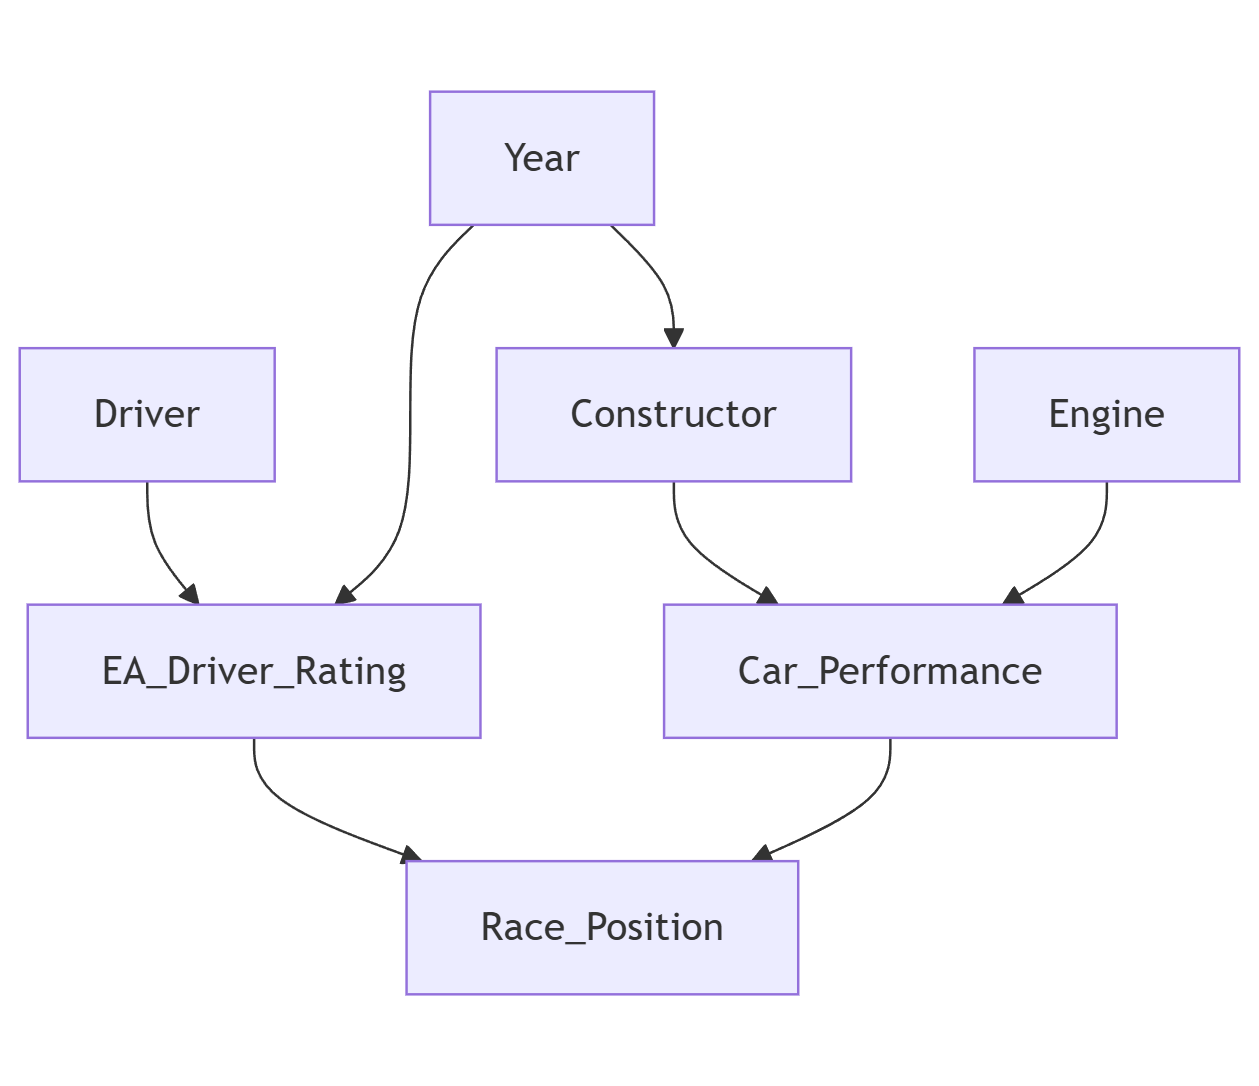

In [1]:
from IPython.display import Image
Image("images/DAG.png")

Why these data were used:

**EA Driver Rating** – an independent, available measure of skill that helps avoid subjective assessments.

**Engine, Constructor** – technical foundations influencing the result, with a clear causal meaning.

**Year + Constructor** – capturing variability between seasons.

We omitted data such as weather, which could cause irregular effects on the model, since races in difficult conditions are hard to predict. The number of pit stops was also excluded because, in a typical race, most teams perform the same number of pit stops, or there are cases where a driver can earn an extra point for the fastest lap. If the team knows they won’t catch the driver ahead or lose position, they may perform this tactical maneuver. However, an increased number of pit stops often occurs due to collisions during the race, meaning the driver might have more pit stops but a significantly lower position. This could confuse the model’s behavior.

DAGs illustrate the main types of confounding structures:

- **Pipe:** e.g., `Engine → Constructor_Performance → Race_Position` – the engine affects the constructor’s performance, which in turn influences the race position.

- **Fork:** e.g., `Year → EA_Driver_Rating` and `Year → Constructor` – the year influences the driver rating (if drivers performed well that year, they have a higher rating) and also affects constructors due to changing vehicle regulations each season.

- **Collider:** `Alpha_driver → Race_Position ← Constructor_Performance` – race outcome depends on both the team’s quality building the car and the skill of the driver racing it.


In [2]:
import numpy as np
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import seaborn as sns
from scipy.special import expit
from numpy.random import binomial

# import logging
# logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

## Data preprocessing [0-2 pts]:
- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]

Data have been preprocessed in separate notebooks, which are available in the `data` directory.
- **Data source:** FastF1, EA Sports F1 game, Wikipedia.
- **Data merging:** Combining data from different seasons to create one large dataset.
- **Data cleaning:** Standardizing team, driver and engine manufacturer names, removing unecessary columns.

In [440]:
df = pd.read_csv('data/processed_data/final_position.csv')

unique_drivers = df['DriverId'].unique()
driver_id_map = {driver: idx + 1 for idx, driver in enumerate(unique_drivers)}
df['DriverId'] = df['DriverId'].map(driver_id_map)
drivers = df['DriverId'].values

unique_team = df['TeamId'].unique()
team_id_map = {team: idx + 1 for idx, team in enumerate(unique_team)}
df['TeamId'] = df['TeamId'].map(team_id_map)
teams = df['TeamId'].values

unique_engine = df['Engine'].unique()
engine_id_map = {engine: idx + 1 for idx, engine in enumerate(unique_engine)}
df['Engine'] = df['Engine'].map(engine_id_map)
engines = df['Engine'].values

unique_season = df['Season'].unique()
season_id_map = {season: idx + 1 for idx, season in enumerate(unique_season)}
df['Season'] = df['Season'].map(season_id_map)
seasons = df['Season'].values

df['Rating_all'] = (df['Rating'] - df['Rating'].mean()) / df['Rating'].std()

In [441]:
def standardize_group(group):
    mean = group['Rating'].mean()
    std = group['Rating'].std()
    group['Rating_by_year'] = (group['Rating'] - mean) / std
    return group

df = df.groupby('Season', group_keys=False, observed=True).apply(standardize_group)
ratings = df['Rating_all'].values
ratings_by_year = df["Rating_by_year"].values
df['Position'] = df['SeasonStanding'].astype(int)

/tmp/ipykernel_22/1376865985.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Season', group_keys=False, observed=True).apply(standardize_group)


In our model, we applied two approaches to standardizing driver rating data. In the first case, standardization was performed on the entire dataset, while in the second, it was done separately for each season.

In [442]:
order_col = ['DriverId', 'Rating_by_year', 'Rating_all', 'TeamId', 'Engine', 'Season','Position']
df = df[order_col]

## Model [0-4 pts]
- are two different models specified [1 pt]
- are difference between two models explained [1 pt]
- is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]
- are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

### Model 1  
  $$
  \text{model} = \alpha_{\text{intercept}} + \alpha_{\text{constructor}} + \alpha_{\text{driver}} \cdot \text{Driver Rating}
  $$

  $$
  \theta = \mathrm{inv\_logit}(\text{model}) = \frac{1}{1 + e^{-\text{model}}}
  $$

  $$
  \text{position} \sim \mathrm{Binomial}(n=19, p=\theta)
  $$


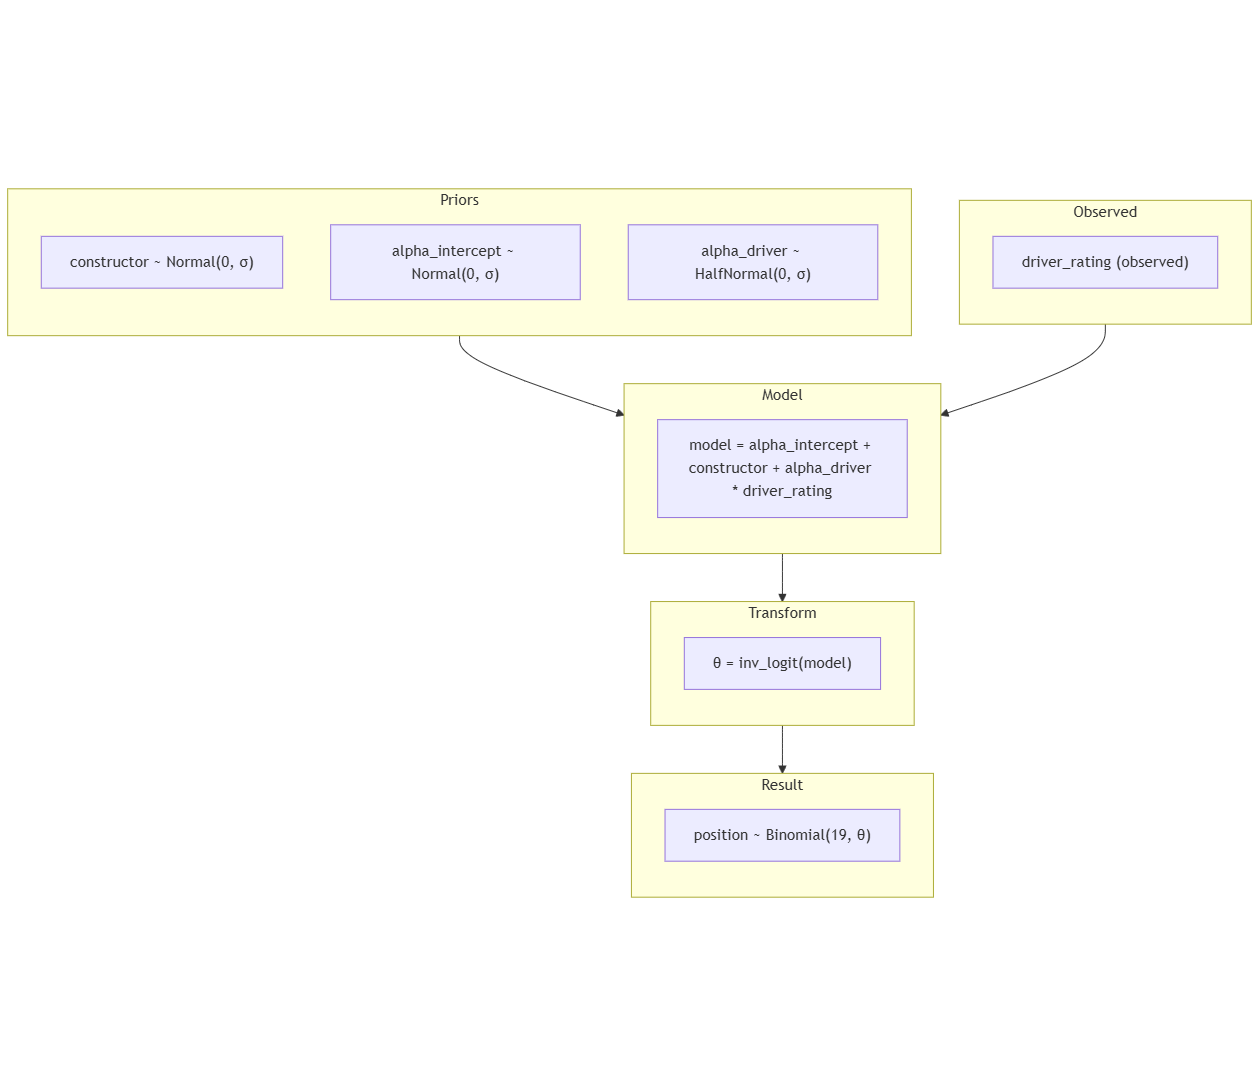

In [423]:
Image("images/model1.png")

### Parameters

- **Constructor** – represents the strength of the team. It can be interpreted as a deviation from the average constructor:

    - **Negative values** → better than average car  
    - **Positive values** → worse than average car  

- **Alpha_Driver** - Coefficient determining how much impact the driver has on the performance.

- **Driver_Rating** - Driver's rating, taken from the EA Sports F1 video game.

- **Intercept** - Represents the baseline performance level across all seasons, teams, and drivers. It captures the average tendency of the model before adjusting for specific effects like constructor, or driver.


### Model 2
  $$
  \text{model} = \alpha_{\text{intercept}} + \alpha_{\text{engine}} + \alpha_{\text{year\_constructor}} + \alpha_{\text{driver}} \cdot \text{Driver Rating}
  $$

  $$
  \theta = \mathrm{inv\_logit}(\text{model}) = \frac{1}{1 + e^{-\text{model}}}
  $$

  $$
  \text{position} \sim \mathrm{Binomial}(n=19, p=\theta)
  $$


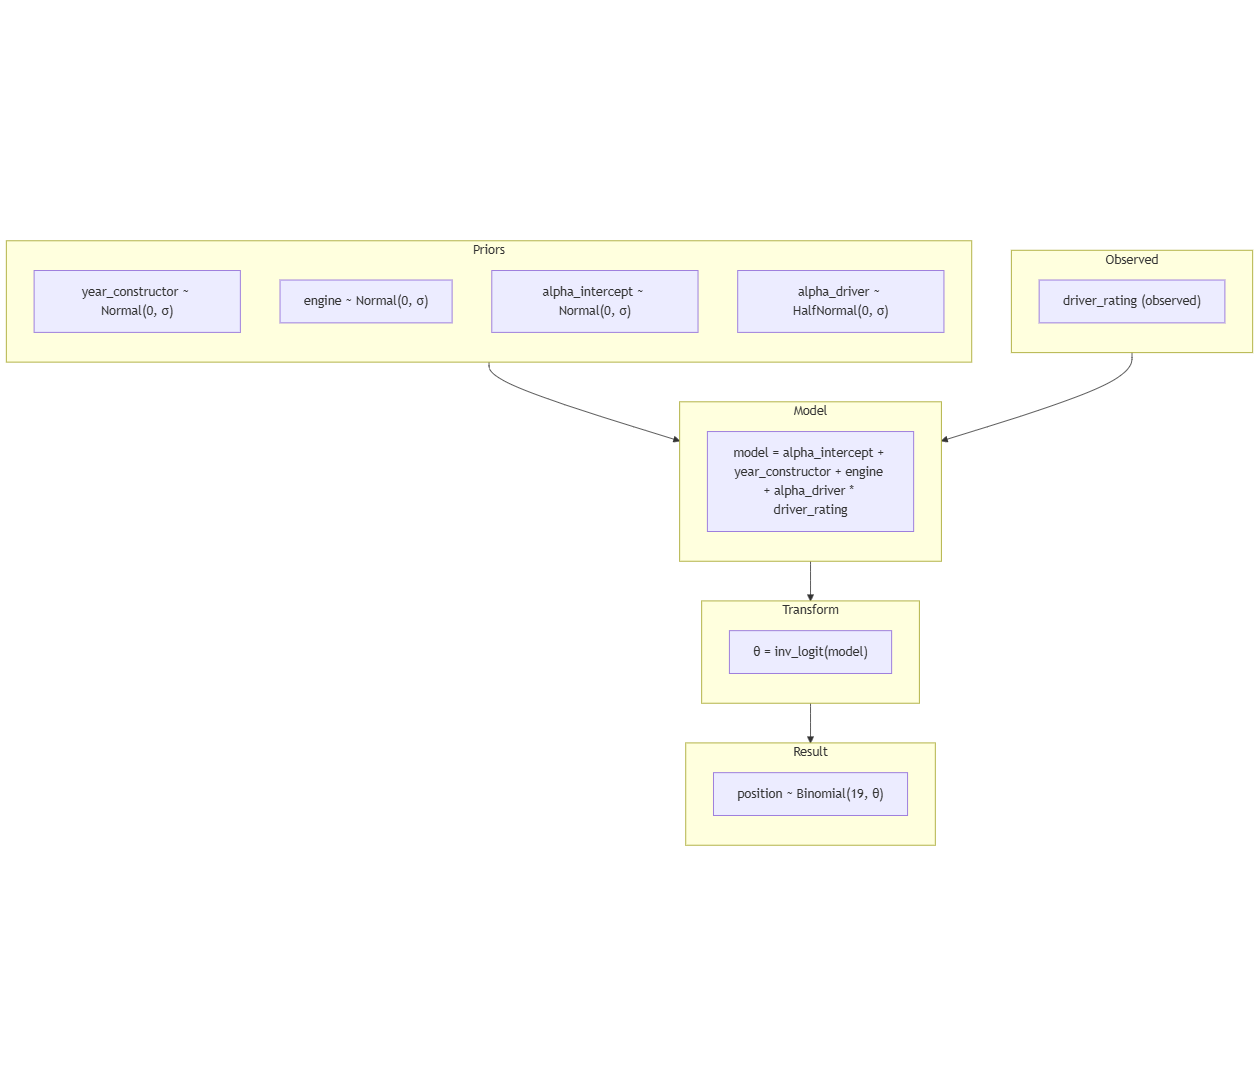

In [424]:
Image("images/model2.png")

### Parameters

- **Constructor** - Represents the team's strength for a given season. It can be interpreted as a deviation from the average constructor:

    - **Negative values** → better than average car  
    - **Positive values** → worse than average car  

- **Engine** - Represents the engine used:
    - **Negative values** → better than average engine  
    - **Positive values** → worse than average engine  


- **Alpha_Driver** - Coefficient determining how much impact the driver has on the performance.

- **Driver_Rating** - Driver's rating, taken from the EA Sports F1 video game.

- **Intercept** - Represents the baseline performance level across all seasons, teams, and drivers. It captures the average tendency of the model before adjusting for specific effects like engine, constructor, or driver.


### Difference between the models

The difference between the first and the second model is based on two main factors. The first is the inclusion of information about the engine manufacturer used by each team. In Formula 1, there are several engine suppliers, and incorporating this parameter allows the analysis to assess how a change in engine supplier affected a team's performance. The second distinguishing factor is the inclusion of temporal parameters. In the first model, we assume that a team is generally strong or weak, whereas in the second model, we account for variations in team performance across different seasons. A well-known example for any fan is the Mercedes team, which dominated from 2014 to 2021 by winning the Constructors' Championships, but has seen a decline in performance since the 2022 season. Differences in how data is fed into the models also result from the different standardization methods used.

### Required Data

- Team performance data across multiple seasons (e.g., race results).  
- Identification of constructor for each team and season.  
- Engine manufacturer information for each team and season.
- Driver rating data taken from the F1 game developed by EA Sports.

## Priors [0-4 pts]
- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

## The Prior tests were prepared for the best, average, and weakest driver.

### Model 1 PPC

In [165]:
model_1_ppc = CmdStanModel(stan_file='stan/model_1_ppc.stan')

12:42:36 - cmdstanpy - INFO - compiling stan file /workspace/F1_bayesian/stan/model_1_ppc.stan to exe file /workspace/F1_bayesian/stan/model_1_ppc
12:42:53 - cmdstanpy - INFO - compiled model executable: /workspace/F1_bayesian/stan/model_1_ppc


In [291]:
def draw_plots_ppc_model_1(driver_rating, positions_real):
    fig, axes = plt.subplots(3, 5, figsize=(20, 10))
    colors = ["#130582", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

    for s_i in range(3):
        sigma = {'sigma': 0.6, 'driver_rating': driver_rating[s_i]}
        model_1_ppc_sim = model_1_ppc.sample(data=sigma, iter_warmup=1000, fixed_param=True, seed=25062025)

        # alpha_driver
        axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('intercept').flatten(), bins=30, density=True, color=colors[0], alpha=0.8)
        axes[s_i, 0].set_yticks([])
        axes[s_i, 0].set_title(f'intercept')

        # alpha_driver
        axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten(), bins=30, density=True, color=colors[1], alpha=0.8)
        axes[s_i, 1].set_yticks([])
        axes[s_i, 1].set_title(f'Driver {s_i+1}: alpha_driver')

        # constructor
        axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('constructor').flatten(), bins=30, density=True, color=colors[2], alpha=0.8)
        axes[s_i, 2].set_yticks([])
        axes[s_i, 2].set_title('constructor')

        # theta
        axes[s_i, 3].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=30, density=True, color=colors[4], alpha=0.8)
        axes[s_i, 3].set_yticks([])
        axes[s_i, 3].set_title('theta')

        # simulated positions + true position
        positions = [20 - x for x in model_1_ppc_sim.stan_variable('y_ppc').flatten()]
        n_bins = np.arange(22) - 0.5
        axes[s_i, 4].hist(positions, bins=n_bins, rwidth=0.85, density=True, color=colors[5], alpha=0.85, label="Simulated")
        axes[s_i, 4].set_xticks(range(1, 21))
        axes[s_i, 4].set_xlim([0.5, 20.5])
        axes[s_i, 4].set_yticks([])
        axes[s_i, 4].set_title('Position')
        true_pos = positions_real[s_i] 
        axes[s_i, 4].axvline(true_pos, color='black', linestyle='--', linewidth=2, label="Actual")
        
    for i in range(4):
        axes[2, i].set_xlabel(['alpha_driver', 'constructor', 'theta', 'Position'][i])

    # Styl
    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='both', which='major')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    fig.suptitle("Prior Predictive Checks for Model 1 (with True Positions)", fontsize=18)
    fig.tight_layout()
    plt.show()


In [292]:
year_2020 = df[df['Season'] == 1]
driver_rating = year_2020['Rating_all'].tolist()
positions_real = year_2020['Position'].tolist()

#### The drivers with the best results.

13:30:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:47 - cmdstanpy - INFO - CmdStan done processing.


13:30:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:48 - cmdstanpy - INFO - CmdStan done processing.


13:30:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:48 - cmdstanpy - INFO - CmdStan done processing.


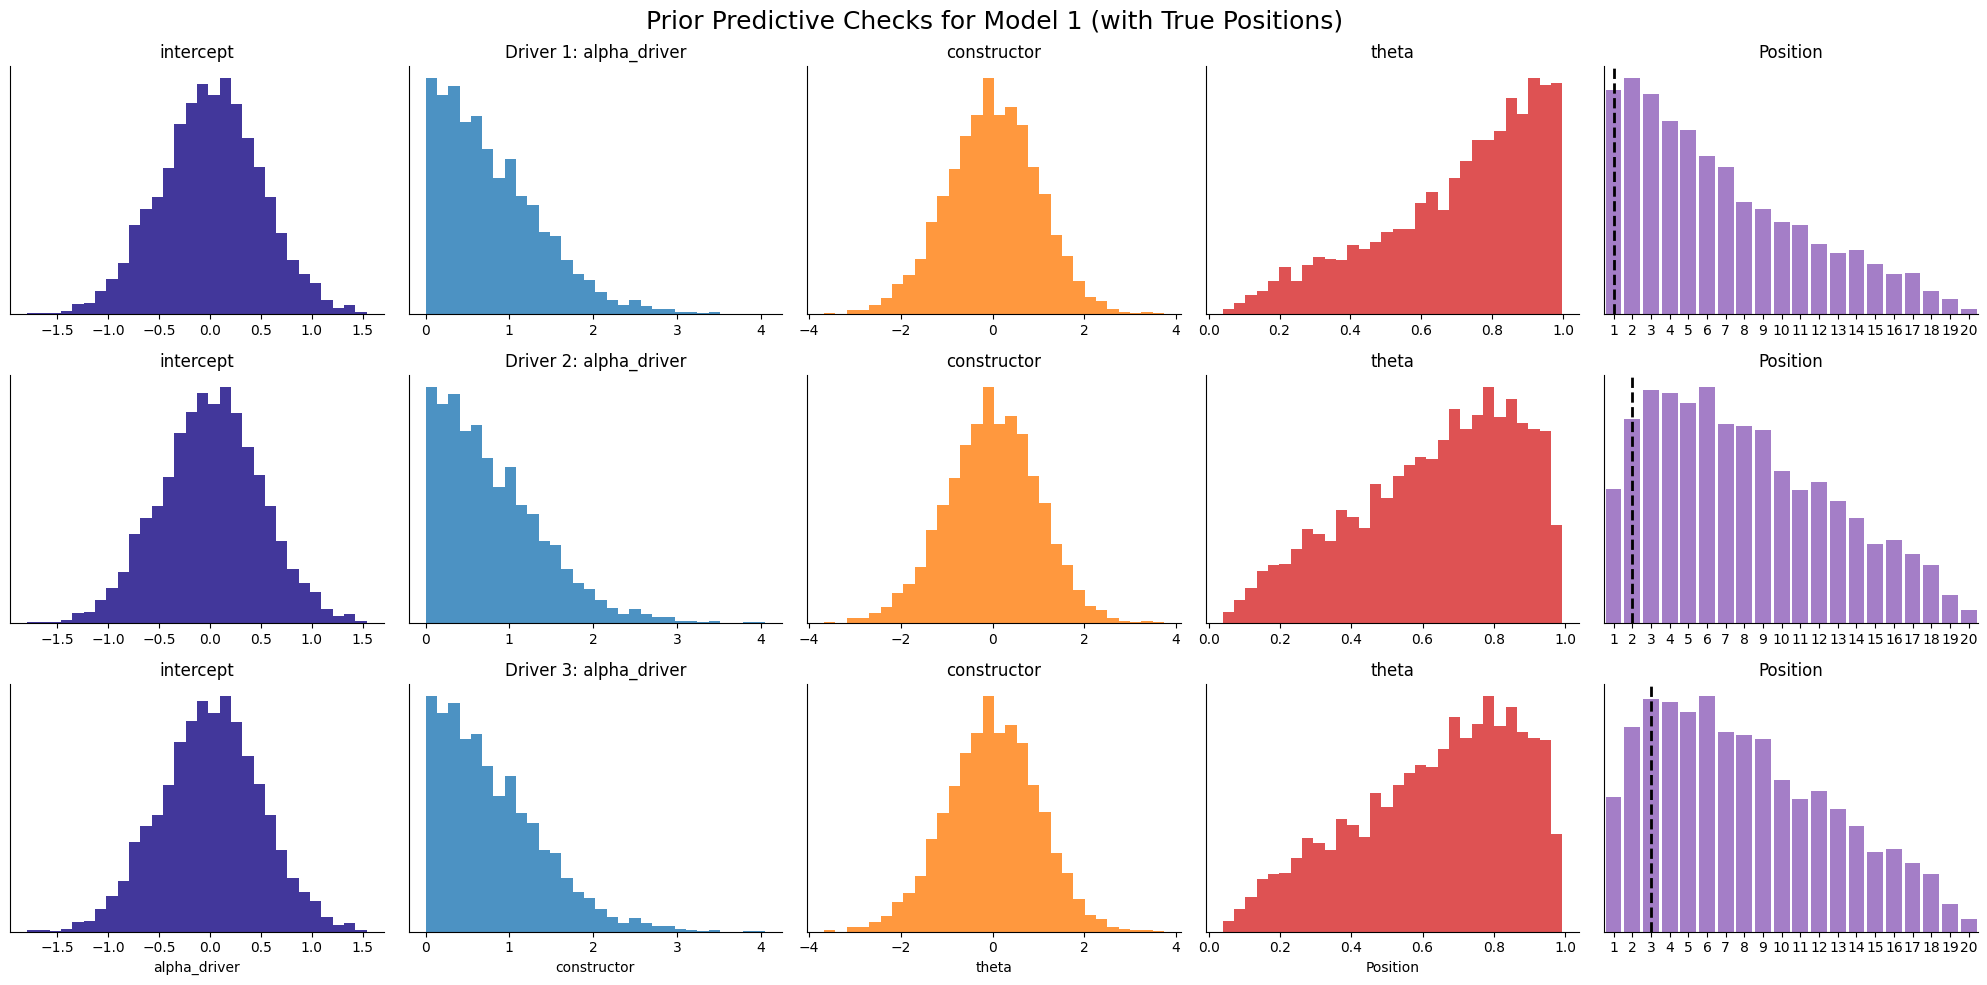

In [293]:
draw_plots_ppc_model_1(driver_rating[:3], positions_real[:3])

#### An average drivers from the middle of the field.

13:30:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:51 - cmdstanpy - INFO - CmdStan done processing.


13:30:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:51 - cmdstanpy - INFO - CmdStan done processing.


13:30:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:51 - cmdstanpy - INFO - CmdStan done processing.


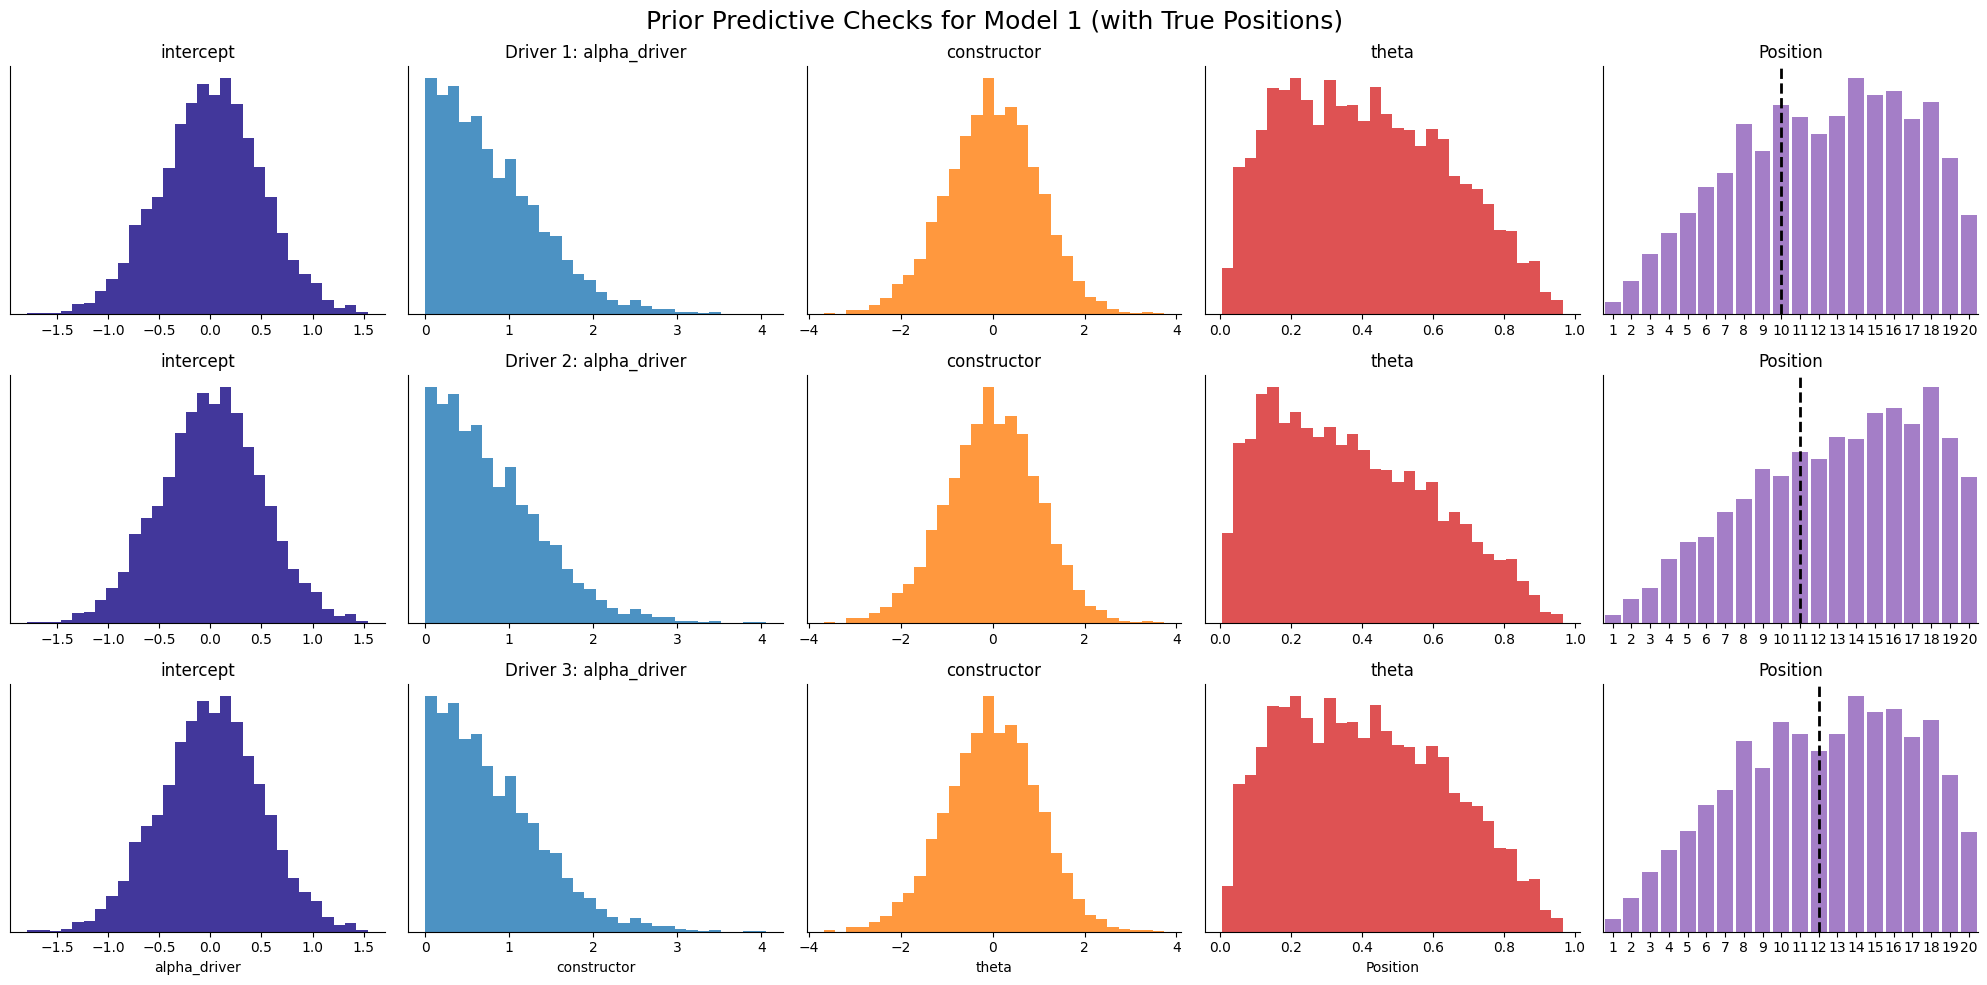

In [294]:
draw_plots_ppc_model_1(driver_rating[9:12], positions_real[9:12])

#### The drivers with the weakest results.

13:30:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:57 - cmdstanpy - INFO - CmdStan done processing.


13:30:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:57 - cmdstanpy - INFO - CmdStan done processing.


13:30:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:30:58 - cmdstanpy - INFO - CmdStan done processing.


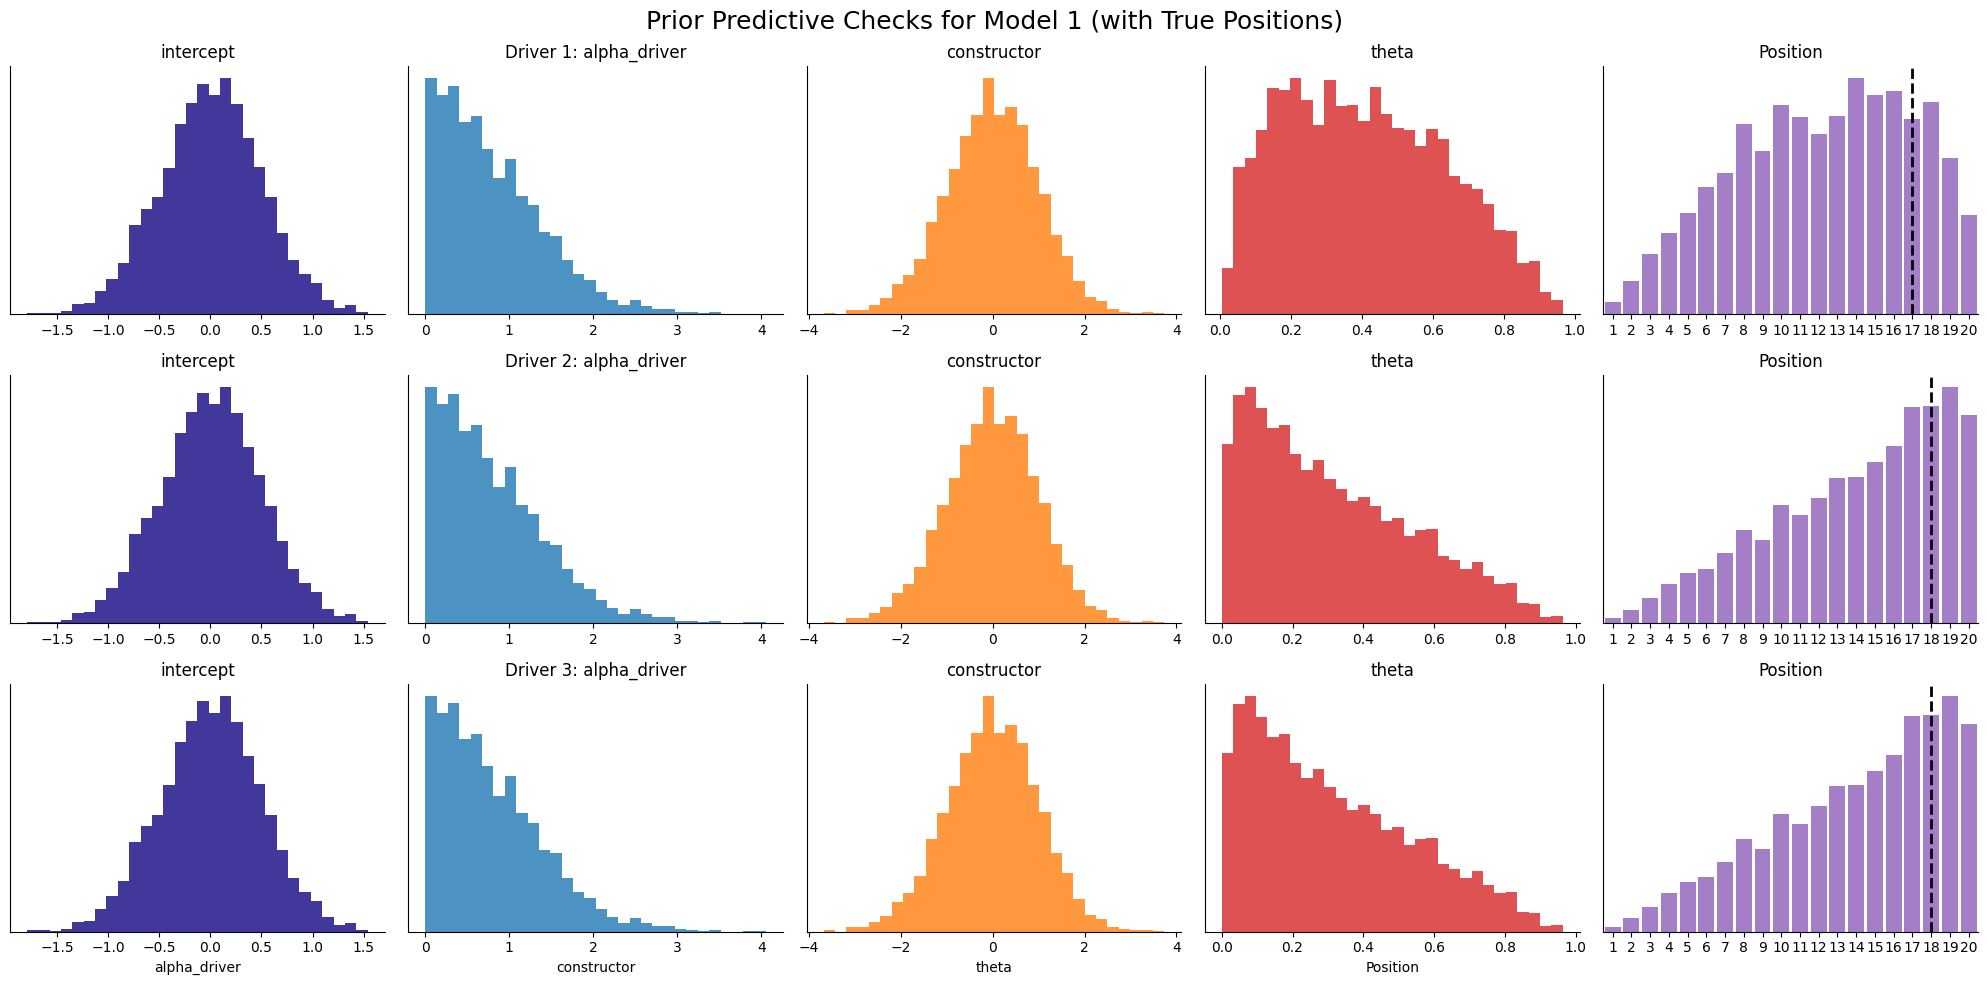

In [295]:
draw_plots_ppc_model_1(driver_rating[16:19], positions_real[16:19])

### Model 2 PPC

In [241]:
model_2_ppc = CmdStanModel(stan_file='stan/model_2_ppc.stan')

13:10:59 - cmdstanpy - INFO - compiling stan file /workspace/F1_bayesian/stan/model_2_ppc.stan to exe file /workspace/F1_bayesian/stan/model_2_ppc
13:11:17 - cmdstanpy - INFO - compiled model executable: /workspace/F1_bayesian/stan/model_2_ppc


In [286]:
def draw_plots_ppc_model_2(driver_rating, positions_real):
    fig, axes = plt.subplots(3, 6, figsize=(24, 10))
    colors = ["#130582", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    
    for s_i in range(3):
        sigma = {'driver_rating': driver_rating[s_i]}
        model_2_ppc_sim = model_2_ppc.sample(data=sigma, iter_warmup=1000, fixed_param=True, seed=25062025)

        # intercept 
        axes[s_i, 0].hist(model_2_ppc_sim.stan_variable('intercept').flatten(), bins=30, density=True, color=colors[0], alpha=0.8)
        axes[s_i, 0].set_yticks([])
        axes[s_i, 0].set_title(f'intercept')

        # engine 
        axes[s_i, 1].hist(model_2_ppc_sim.stan_variable('engine').flatten(), bins=30, density=True, color=colors[1], alpha=0.8)
        axes[s_i, 1].set_yticks([])
        axes[s_i, 1].set_title(f'alpha_engine')

        # alpha_driver
        axes[s_i, 2].hist(model_2_ppc_sim.stan_variable('alpha_driver').flatten(), bins=30, density=True, color=colors[2], alpha=0.8)
        axes[s_i, 2].set_yticks([])
        axes[s_i, 2].set_title(f'alpha_driver')

        # constructor
        axes[s_i, 3].hist(model_2_ppc_sim.stan_variable('year_constructor').flatten(), bins=30, density=True, color=colors[3], alpha=0.8)
        axes[s_i, 3].set_yticks([])
        axes[s_i, 3].set_title('year_constructor')

        # theta
        axes[s_i, 4].hist(model_2_ppc_sim.stan_variable('theta').flatten(), bins=30, density=True, color=colors[4], alpha=0.8)
        axes[s_i, 4].set_yticks([])
        axes[s_i, 4].set_title('theta')

        # simulated positions + true position
        positions = [20 - x for x in model_2_ppc_sim.stan_variable('y_ppc').flatten()]
        n_bins = np.arange(22) - 0.5
        axes[s_i, 5].hist(positions, bins=n_bins, rwidth=0.85, density=True, color=colors[5], alpha=0.85, label="Simulated")
        axes[s_i, 5].set_xticks(range(1, 21))
        axes[s_i, 5].set_xlim([0.5, 20.5])
        axes[s_i, 5].set_yticks([])
        axes[s_i, 5].set_title('Position')

        true_pos = positions_real[s_i] 
        axes[s_i, 5].axvline(true_pos, color='black', linestyle='--', linewidth=2, label="Actual")
        
    for i in range(4):
        axes[2, i].set_xlabel(['intercept', 'engine', 'alpha_driver', 'year_constructor', 'theta', 'Position'][i])

    # Styl
    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='both', which='major')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    fig.suptitle("Prior Predictive Checks for Model 2 (with True Positions)", fontsize=18)
    fig.tight_layout()
    plt.show()
    

In [287]:
year_2020 = df[df['Season'] == 1]
driver_rating = year_2020['Rating_by_year'].tolist()
positions_real = year_2020['Position'].tolist()

#### The drivers with the best results.

13:25:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:25:53 - cmdstanpy - INFO - CmdStan done processing.


13:25:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:25:53 - cmdstanpy - INFO - CmdStan done processing.


13:25:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:25:53 - cmdstanpy - INFO - CmdStan done processing.


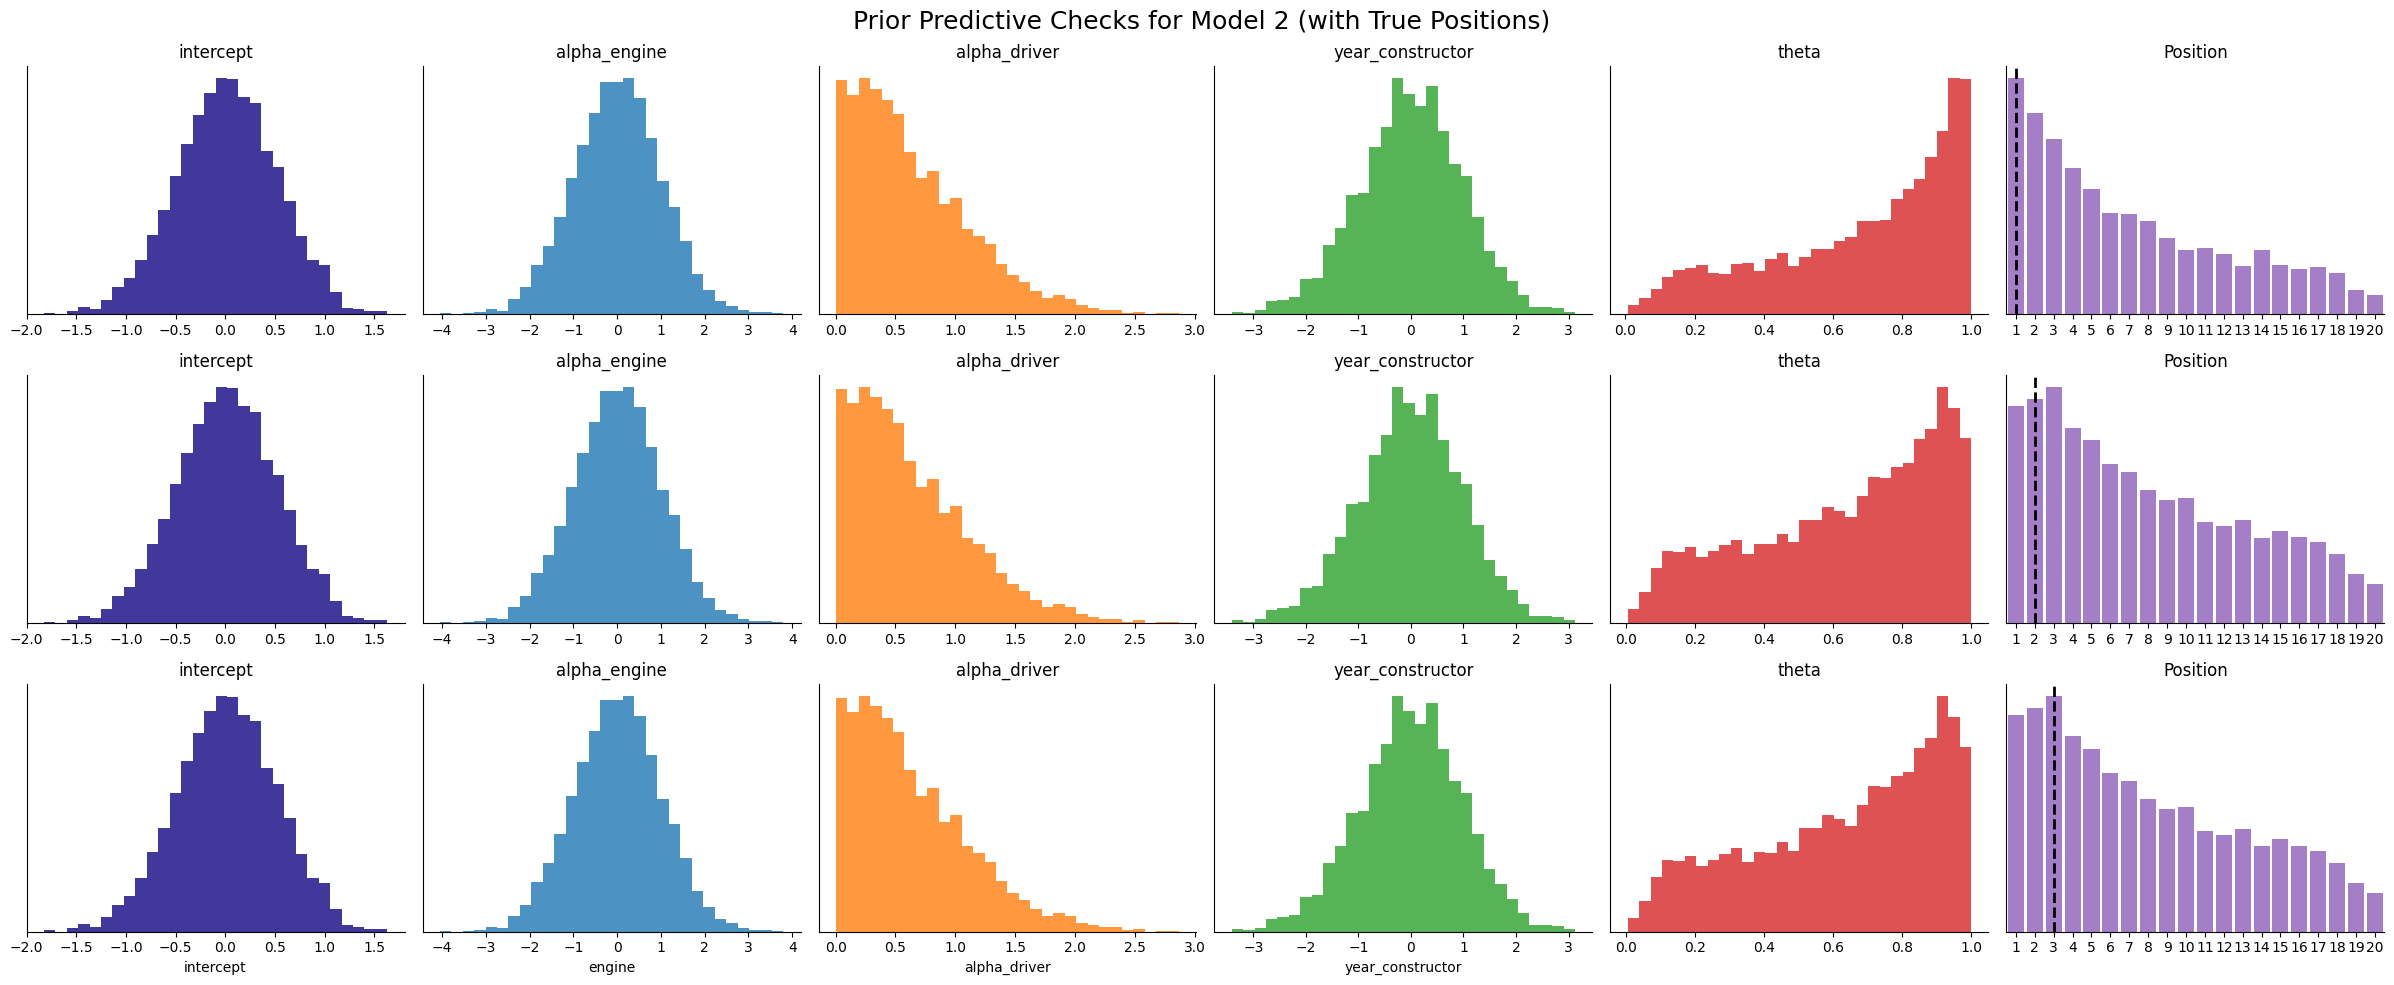

In [288]:
draw_plots_ppc_model_2(driver_rating[:3], positions_real[:3])

#### An average drivers from the middle of the field.

13:26:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:00 - cmdstanpy - INFO - CmdStan done processing.
13:26:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:00 - cmdstanpy - INFO - CmdStan done processing.


13:26:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:00 - cmdstanpy - INFO - CmdStan done processing.


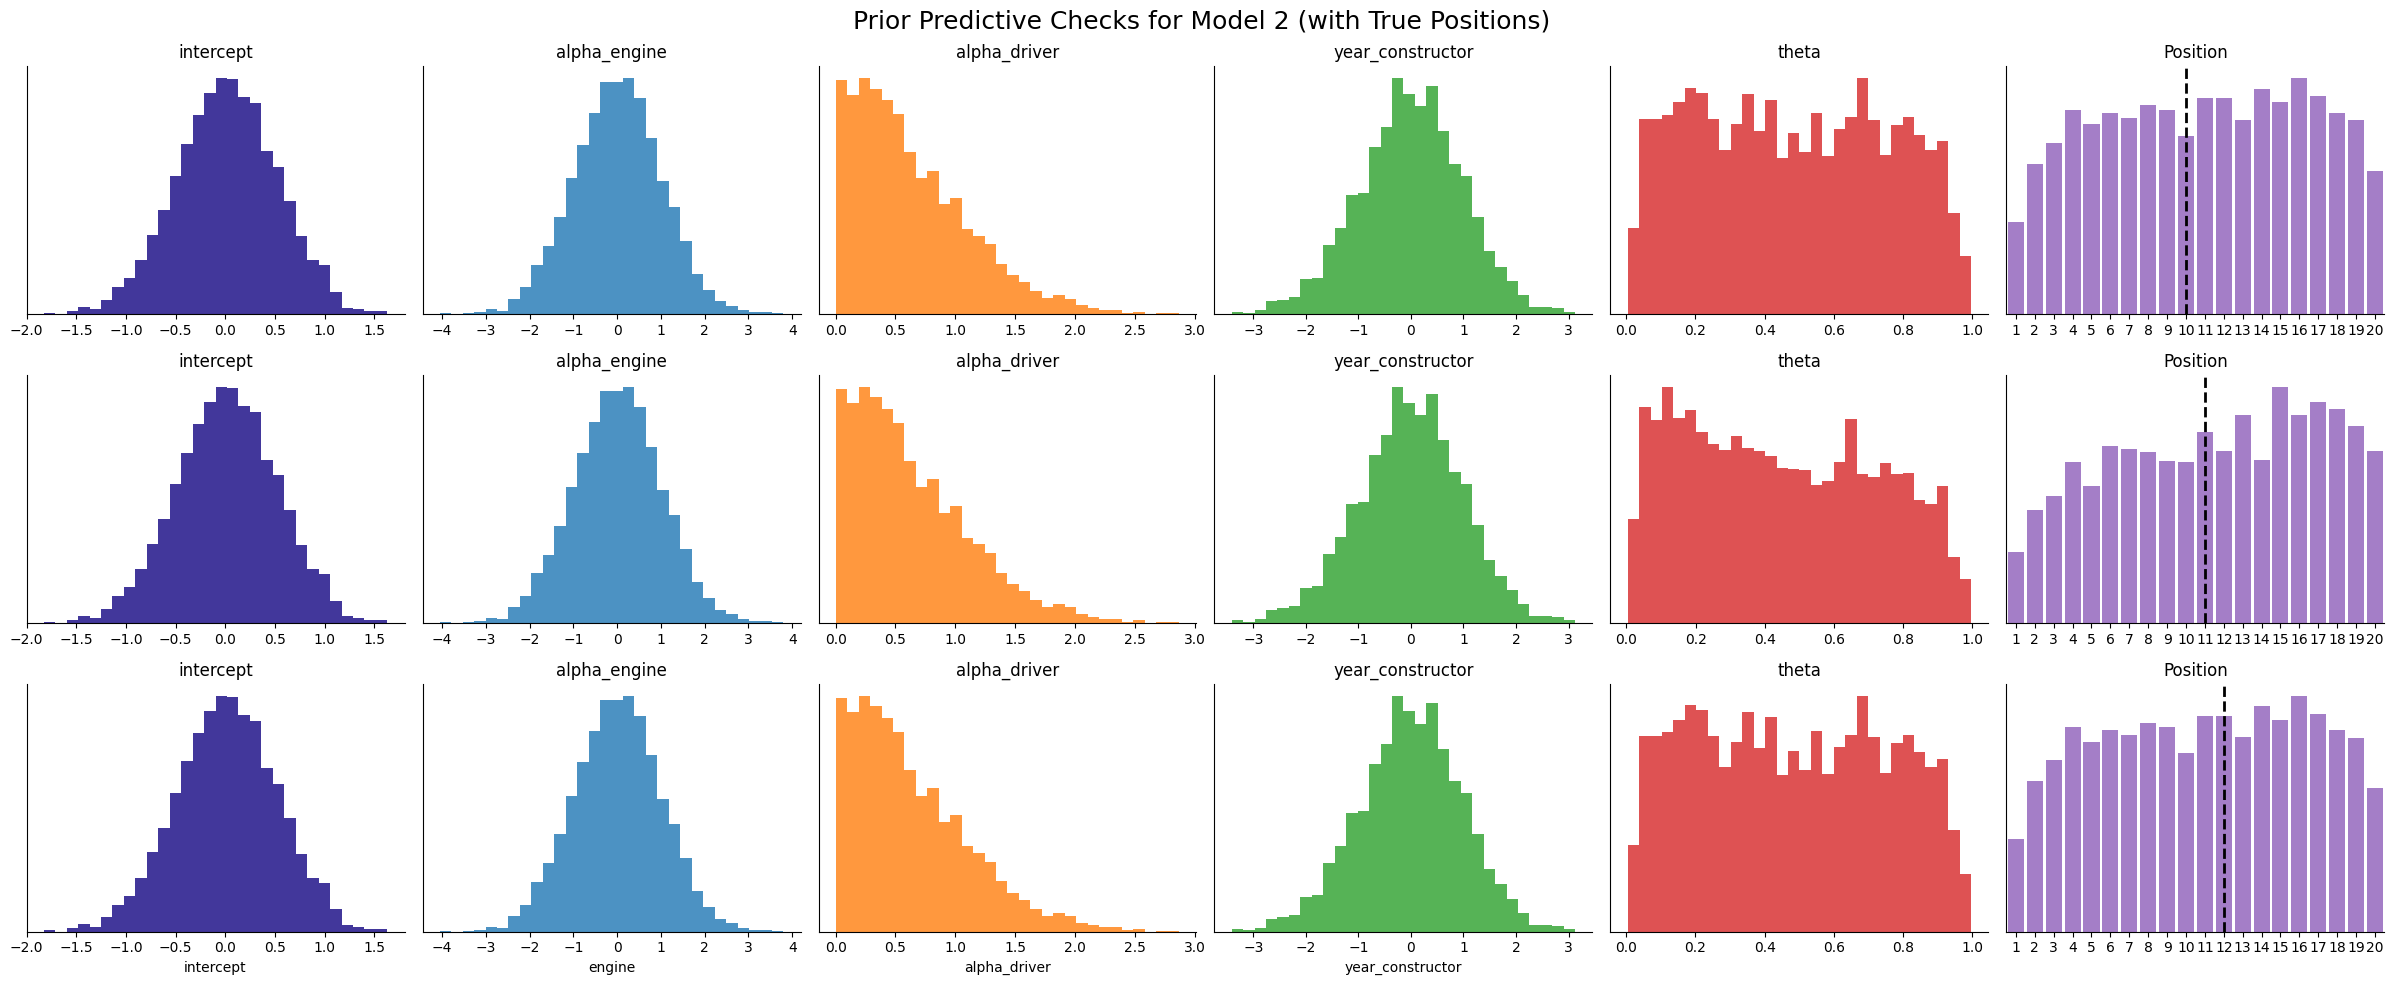

In [289]:
draw_plots_ppc_model_2(driver_rating[9:12], positions_real[9:12])

#### The drivers with the weakest results.

13:26:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:02 - cmdstanpy - INFO - CmdStan done processing.


13:26:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:03 - cmdstanpy - INFO - CmdStan done processing.


13:26:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:26:03 - cmdstanpy - INFO - CmdStan done processing.


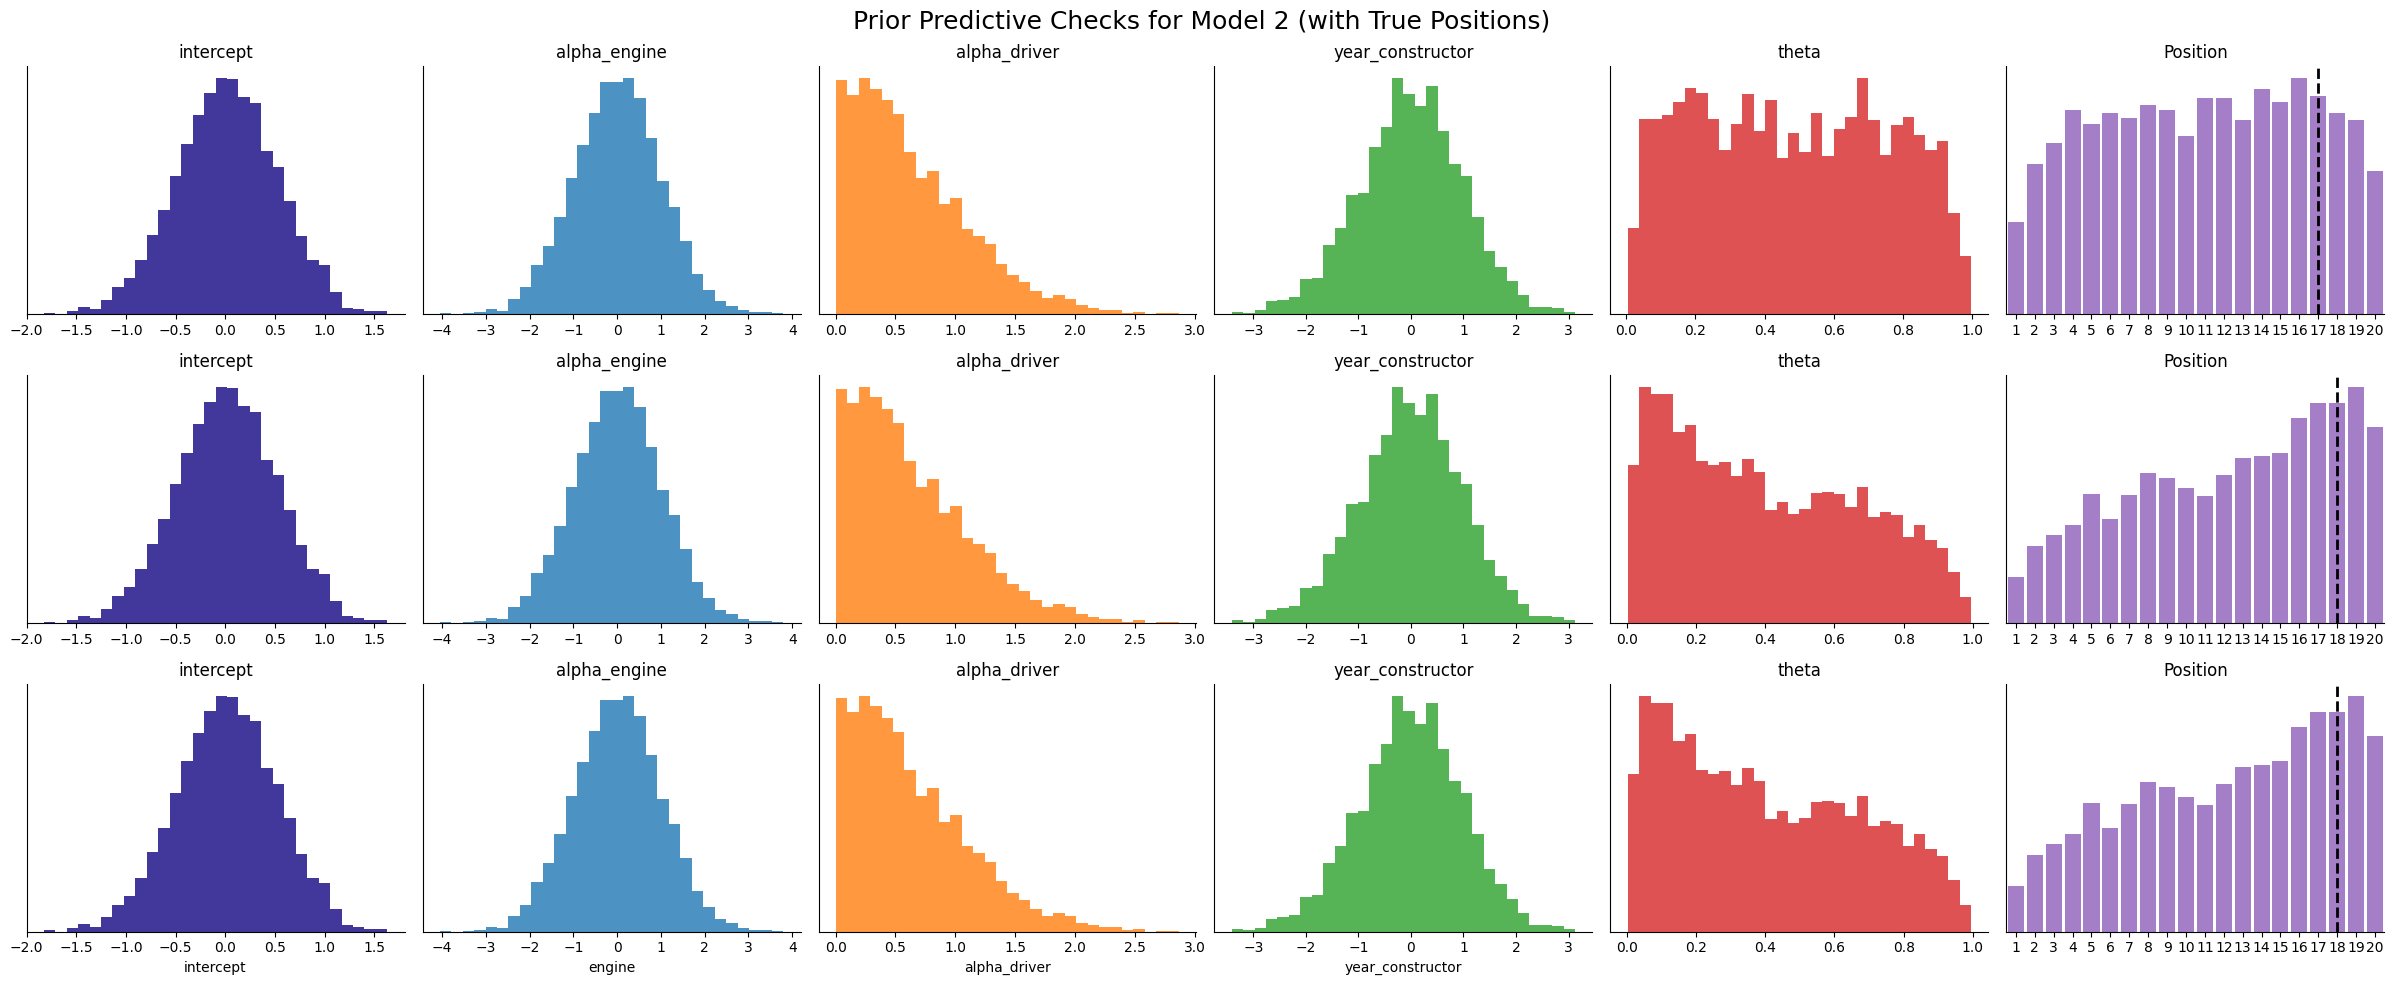

In [290]:
draw_plots_ppc_model_2(driver_rating[16:19], positions_real[16:19])

### Prior Selection and Justification

The choice of normal priors followed van Kesteren and Bergkamp (2023), who demonstrated their suitability in hierarchical models of performance. Normal distributions were selected due to their symmetry, interpretability, and compatibility with multilevel modeling assumptions. For the all component, the prior was centered at μ = 0. For the first model, σ = 1 for both the constructor alpha and the driver alpha, while for the intercept it is 0.5. The distribution for the driver rating is HalfNormal. For the second model, μ = 0, with σ = 1 for both engine and constructor, 0.8 for drivers, and the intercept is again set to 0.5 based on prior predictive checks.

## Posterior analysis (model 1) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

There was no issue with sampling.

In [335]:
def plot_post_3(model_fit, drivers_names):
    fig, axes = plt.subplots(1, len(drivers_names), figsize=(5 * len(drivers_names), 4), sharey=True)

    n_bins = np.arange(22) - 0.5

    for d_i, d_name in enumerate(drivers_names):
        ax = axes[d_i]
        driver_id = driver_id_map[d_name]
        results = df[(df['DriverId'] == driver_id) & (df['Season'] == 4)]
        results_idx = results.index


        ax.axvline(results['Position'].tolist(), color='black', linestyle='--', linewidth=2, label="Observed")

        ax.hist(20 - model_fit.stan_variable('y_hat').T[results_idx].flatten(),
                bins=n_bins,
                rwidth=0.9,
                color='cornflowerblue',
                edgecolor='royalblue',
                alpha=0.7,
                density=True,
                label='Simulated')

        ax.set_xticks(range(22))
        ax.set_xlim([0.5, 20.5])
        ax.set_yticks([])
        ax.set_title(d_name.upper() + '\nfinishing positions 2023', fontsize=11)
        ax.set_xlabel('Position')
        ax.legend(loc='upper right', fontsize=8)

    fig.tight_layout()
    plt.show()

In [425]:
model_1 = CmdStanModel(stan_file='stan/model_1.stan')

In [429]:
model_1_data = {'N': len(df),
                'C': len([*team_id_map.values()]),
                'D': len([*driver_id_map.values()]),
                'driver_rating': ratings,
                'constructor': teams,                
                'driver': drivers,
                'position': 20 - df['Position']} 

model_1_fit = model_1.sample(data=model_1_data, seed=25062025, iter_warmup=1000)

14:48:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:48:30 - cmdstanpy - INFO - CmdStan done processing.


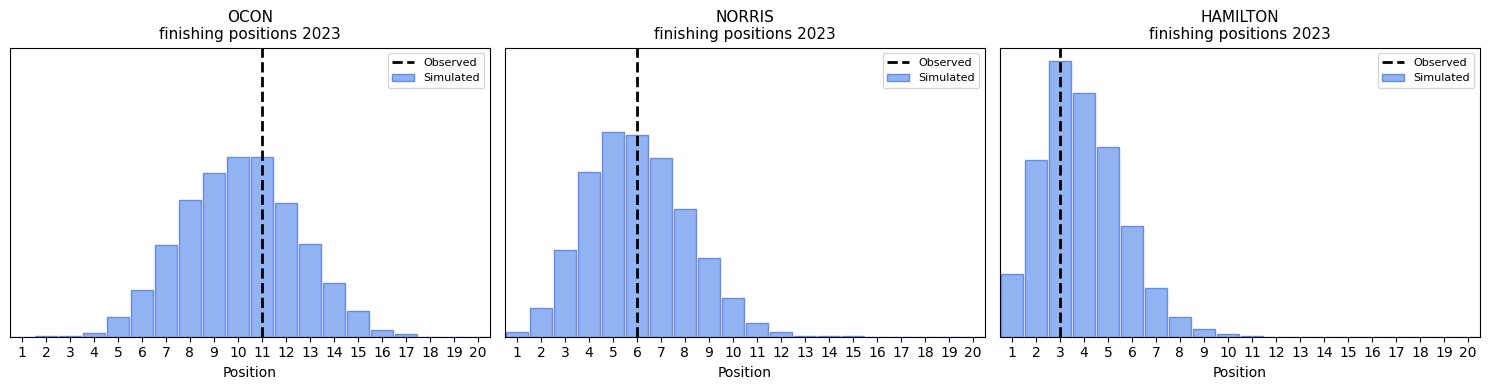

In [430]:
drivers_names = ['ocon', 'norris', 'hamilton']
plot_post_3(model_1_fit, drivers_names)

### Parameter Marginal Distributions

#### Alpha Driver distribution

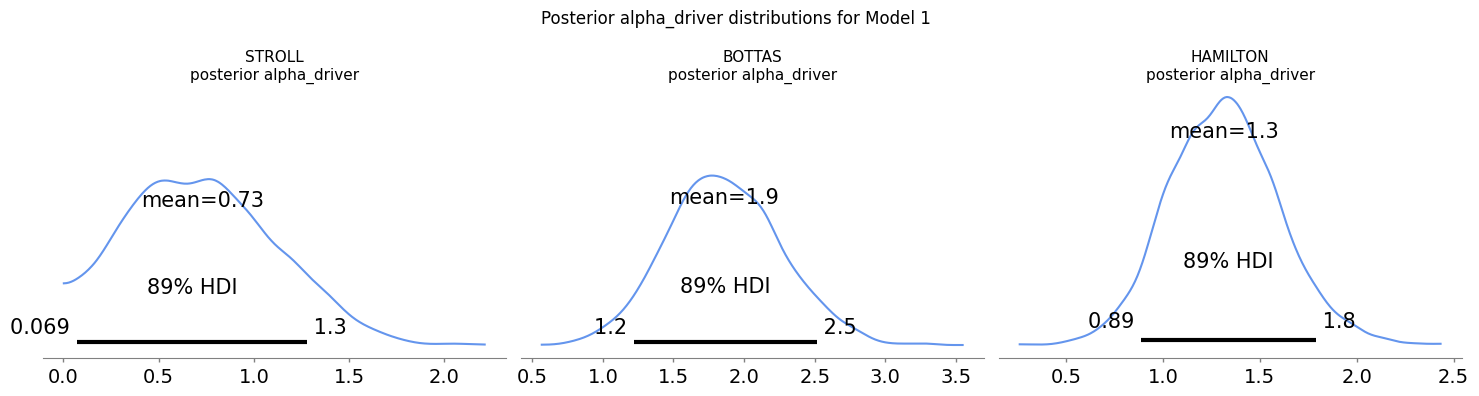

In [431]:
drivers_names = ['stroll', 'bottas', 'hamilton']
fig, axes = plt.subplots(1, len(drivers_names), figsize=(5 * len(drivers_names), 4), sharey=True)

for d_i, d_name in enumerate(drivers_names):
    driver_id = driver_id_map[d_name]
    az.plot_posterior(model_1_fit, var_names=["alpha_driver"], coords={"alpha_driver_dim_0": [driver_id - 1]}, ax=axes[d_i], color='cornflowerblue', hdi_prob=0.89)
    axes[d_i].set_title(d_name.upper() + '\nposterior alpha_driver', fontsize=11)

fig.suptitle("Posterior alpha_driver distributions for Model 1")
fig.tight_layout()
plt.show()

#### Alpha constructor distribution

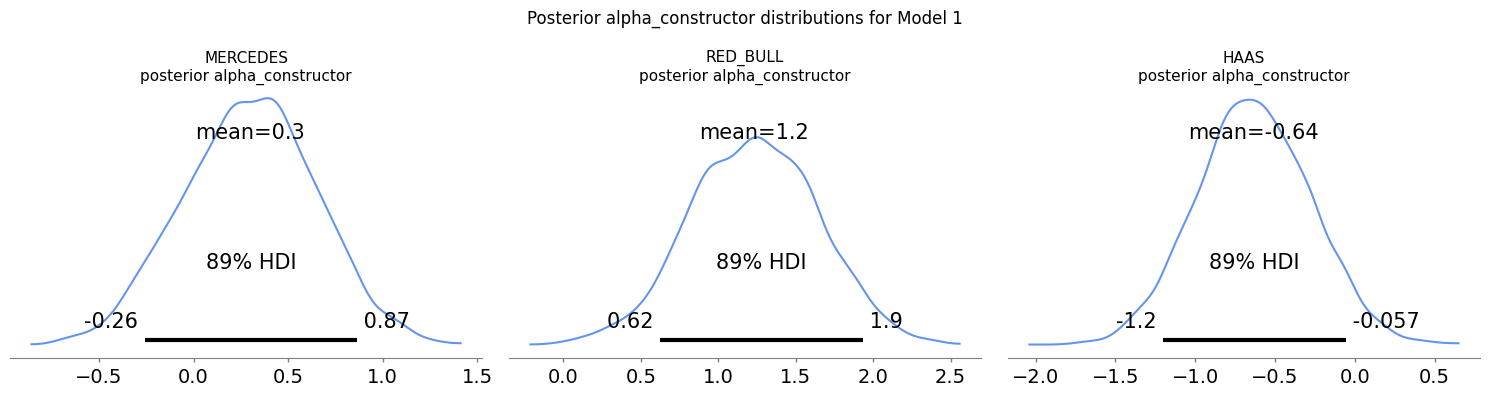

In [460]:
constructor_names = ['mercedes', 'red_bull', 'haas']
fig, axes = plt.subplots(1, len(constructor_names), figsize=(5 * len(constructor_names), 4), sharey=True)

for c_i, c_name in enumerate(constructor_names):
    constructor_id = team_id_map[c_name]
    az.plot_posterior(model_1_fit, var_names=["alpha_constructor"], coords={"alpha_constructor_dim_0": [constructor_id - 1]}, ax=axes[c_i], color='cornflowerblue', hdi_prob=0.89)
    axes[c_i].set_title(c_name.upper() + '\nposterior alpha_constructor', fontsize=11)

fig.suptitle("Posterior alpha_constructor distributions for Model 1")
fig.tight_layout()
plt.show()

### Driver skill trajectories

In [448]:
driver = az.summary(model_1_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.50)

driversID_in_2023 = df[df.loc[:, 'Season']==season_id_map[2023]]['DriverId'].unique()

processed_driver = {
    key.split('_')[-1].capitalize(): value
    for key, value in driver_id_map.items()
}

driver['Driver_id'] = processed_driver.values()
driver['Driver_name'] = processed_driver.keys()
driver_2023 = driver[driver['Driver_id'].isin(driversID_in_2023)]
drivers_in_2023 = driver_2023['Driver_name'].tolist()
driver_2023 = driver_2023.merge(ratings_2023, left_on='Driver_id', right_on='DriverId', how='left')
driver_2023['Skill_weighted_alpha'] = driver_2023['mean'] * driver_2023['Rating_all']
driver_2023['Skill_weighted_2_5'] = driver_2023['hdi_25%'] * driver_2023['Rating_all']
driver_2023['Skill_weighted_97_5'] = driver_2023['hdi_75%'] * driver_2023['Rating_all']
driver_sorted = driver_2023.sort_values(by=['Skill_weighted_alpha'], ascending=True)
driver_sorted.reset_index(drop=True, inplace=True)

In [450]:
driver_rating = df[['DriverId', 'Rating_all', 'Season']]
driver_model1 = driver.merge(driver_rating, left_on='Driver_id', right_on='DriverId', how='left')

In [451]:
driver_model1['Skill_weighted_alpha'] = driver_model1['mean'] * driver_model1['Rating_all']
driver_model1['Skill_weighted_2_5'] = driver_model1['hdi_25%'] * driver_model1['Rating_all']
driver_model1['Skill_weighted_97_5'] = driver_model1['hdi_75%'] * driver_model1['Rating_all']

In [452]:
n_seasons = df['Season'].nunique()
driver_season_counts = driver_model1.groupby('DriverId')['Season'].nunique()
drivers_in_all_seasons = driver_season_counts[driver_season_counts == n_seasons].index
df_filtered = driver_model1[driver_model1['DriverId'].isin(drivers_in_all_seasons)]
year_index_to_name = {v: k for k, v in season_id_map.items()}
df_filtered['Year'] = df_filtered['Season'].map(year_index_to_name)

/tmp/ipykernel_22/2372200589.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = df_filtered['Season'].map(year_index_to_name)


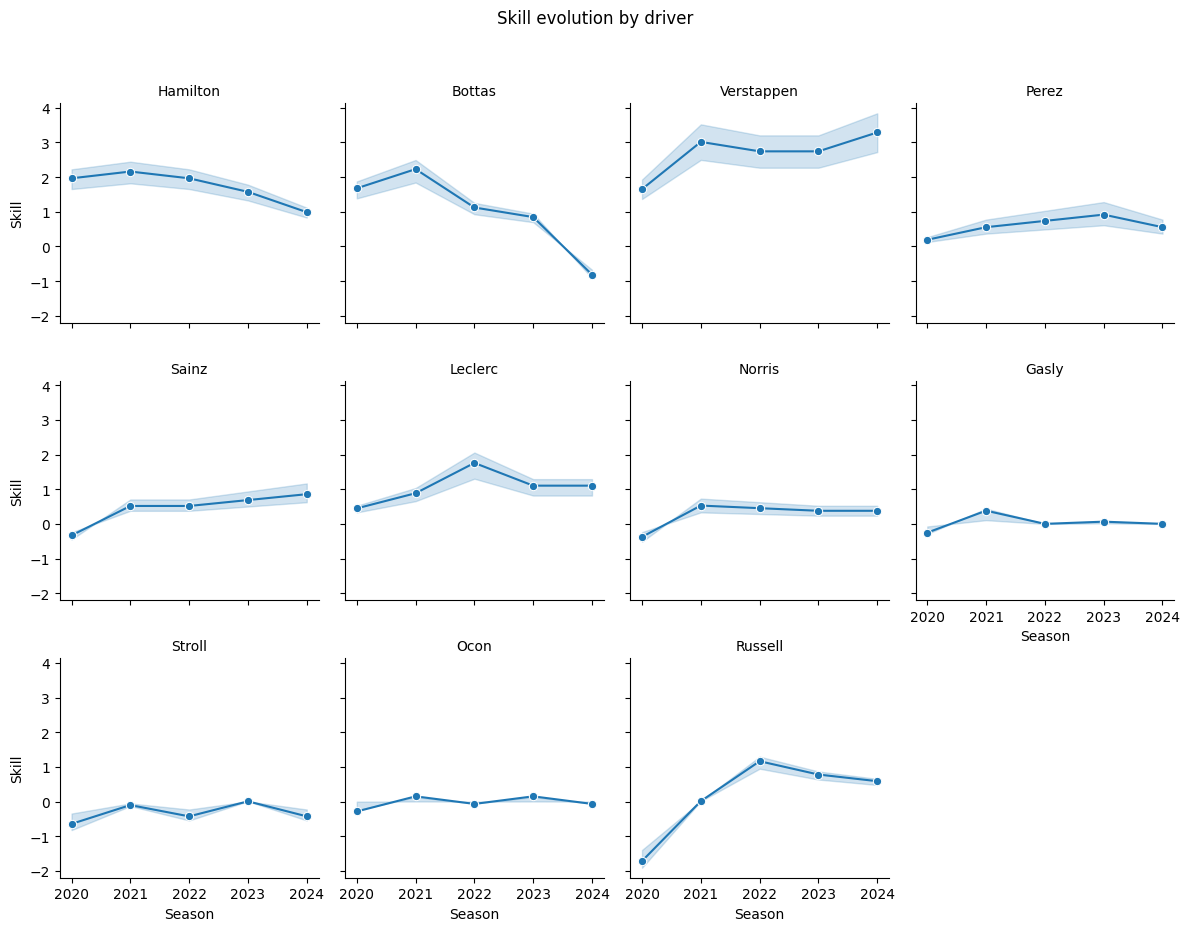

In [454]:
g = sns.FacetGrid(df_filtered, col='Driver_name', col_wrap=4, height=3, sharey=True)

g.map_dataframe(
    sns.lineplot, x='Year', y='Skill_weighted_alpha', marker='o'
)
g.map_dataframe(
    plt.fill_between, 'Year', 'Skill_weighted_2_5', 'Skill_weighted_97_5', alpha=0.2
)
g.set_axis_labels("Season", "Skill")
g.set_titles("{col_name}")
g.fig.suptitle("Skill evolution by driver", y=1.03)
plt.tight_layout()
plt.show()

### Constructor Rating

In [472]:
constructor = az.summary(model_1_fit, var_names=['alpha_constructor'], kind='stats', hdi_prob=.50)

processed_teams = {
    key.split('_')[-1].capitalize(): value
    for key, value in team_id_map.items()
}
processed_teams["Red_Bull"] = processed_teams.pop('Bull')
processed_teams["Racing_Bulls"] = processed_teams.pop('Rb')
processed_teams["Aston_Martin"] = processed_teams.pop('Martin')
sorted_teams = dict(sorted(processed_teams.items(), key=lambda item: item[1]))

constructor['Constructor_id'] = sorted_teams.values()
constructor['Constructor_name'] = sorted_teams.keys()

constructor_list = constructor['Constructor_name'].tolist()

constructor_sorted = constructor.sort_values(by=['mean'], ascending=True)
constructor_sorted.reset_index(drop=True, inplace=True)

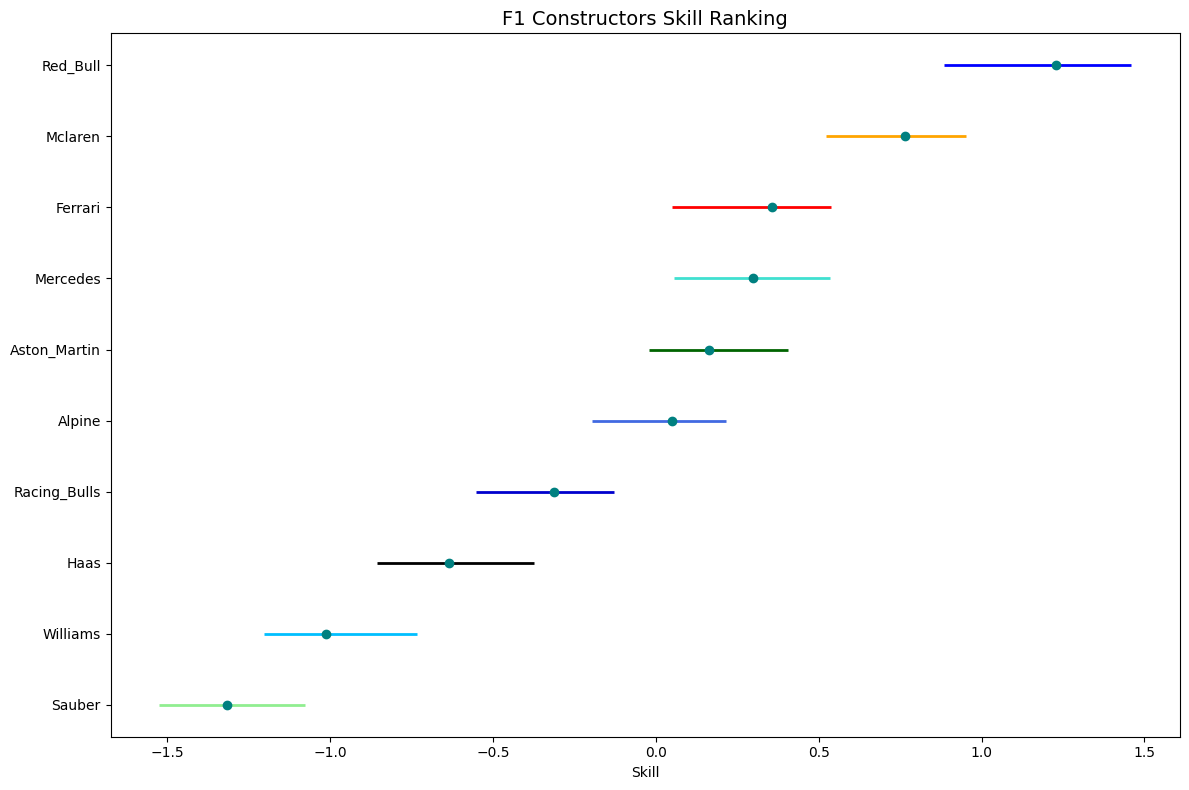

In [473]:
constructor_color = {'Ferrari': 'red', 'Mercedes': 'turquoise', 'Red_Bull': 'blue', 
                     'Williams': 'deepskyblue', 'Aston_Martin': 'darkgreen', 
                     'Racing_Bulls': 'mediumblue', 'Alpine': 'royalblue', 
                     'Sauber': 'lightgreen', 'Mclaren': 'orange', 'Haas': 'k'}

fig, ax = plt.subplots(figsize=(12, 8))

for i, row in constructor_sorted.iterrows():
    y = i
    x_mean = row['mean']
    x_min = row['hdi_25%']
    x_max = row['hdi_75%']

    ax.hlines(y, x_min, x_max, color=constructor_color[row['Constructor_name']], linewidth=2)

    ax.plot(x_mean, y, 'o', color='teal')

ax.set_yticks(range(len(constructor_sorted)))
ax.set_yticklabels(constructor_sorted['Constructor_name'], fontsize=10)

ax.set_xlabel("Skill")
ax.set_title("F1 Constructors Skill Ranking", fontsize=14)

plt.tight_layout()
plt.show()

## Posterior analysis (model 2) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [381]:
model_2 = CmdStanModel(stan_file='stan/model_2.stan')

14:03:39 - cmdstanpy - INFO - compiling stan file /workspace/F1_bayesian/stan/model_2.stan to exe file /workspace/F1_bayesian/stan/model_2
14:04:23 - cmdstanpy - INFO - compiled model executable: /workspace/F1_bayesian/stan/model_2


In [382]:
model_2_data = {'N': len(df),
                'C': len([*team_id_map.values()]),
                'E': len([*engine_id_map.values()]),
                'D': len([*driver_id_map.values()]),
                'Y': len([*season_id_map.values()]),
                'driver_rating': ratings_by_year,
                'engine': engines,
                'constructor': teams,                
                'driver': drivers,
                'year': seasons,
                'position': 20 - df['Position']} 

model_2_fit = model_2.sample(data=model_2_data, seed=25062025, iter_warmup=1000)

14:04:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:04:25 - cmdstanpy - INFO - CmdStan done processing.


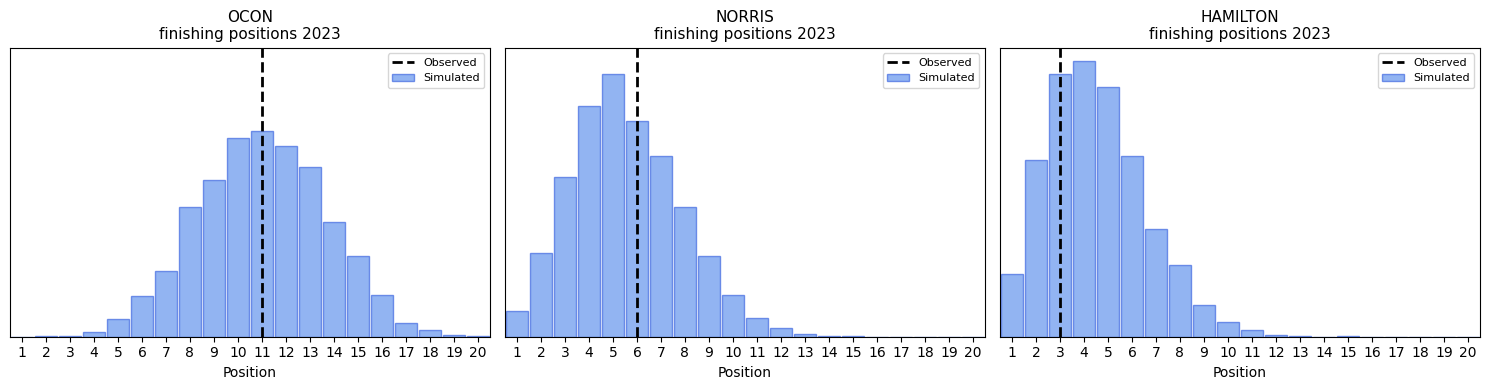

In [383]:
drivers_names = ['ocon', 'norris', 'hamilton']
plot_post_3(model_2_fit, drivers_names)

### Parameter Marginal Distributions

#### Alpha Driver distribution

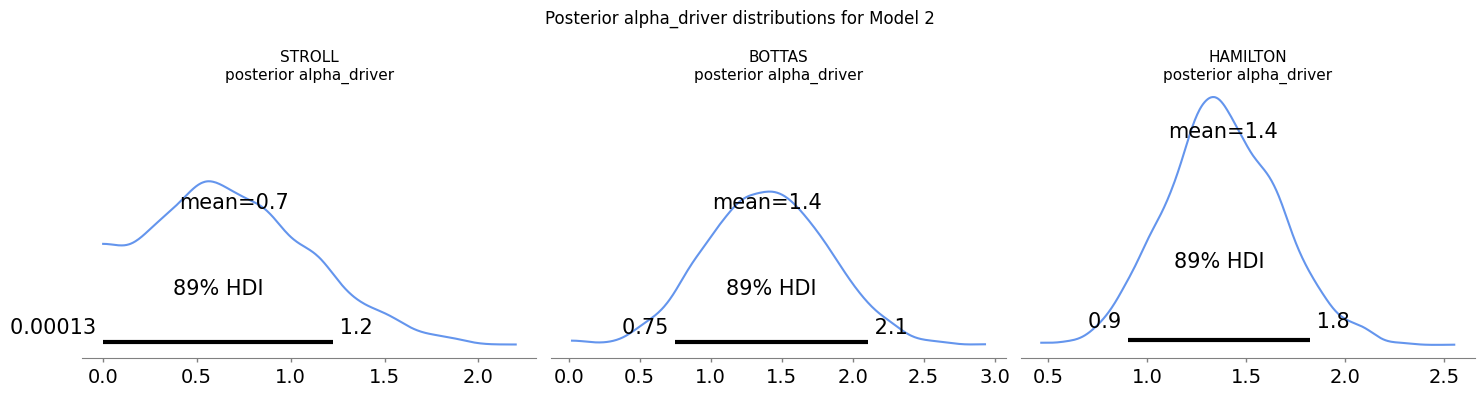

In [384]:
drivers_names = ['stroll', 'bottas', 'hamilton']
fig, axes = plt.subplots(1, len(drivers_names), figsize=(5 * len(drivers_names), 4), sharey=True)

for d_i, d_name in enumerate(drivers_names):
    driver_id = driver_id_map[d_name]
    az.plot_posterior(model_2_fit, var_names=["alpha_driver"], coords={"alpha_driver_dim_0": [driver_id - 1]}, ax=axes[d_i], color='cornflowerblue', hdi_prob=0.89)
    axes[d_i].set_title(d_name.upper() + '\nposterior alpha_driver', fontsize=11)

fig.suptitle("Posterior alpha_driver distributions for Model 2")
fig.tight_layout()
plt.show()

#### Alpha Construtor year distribution

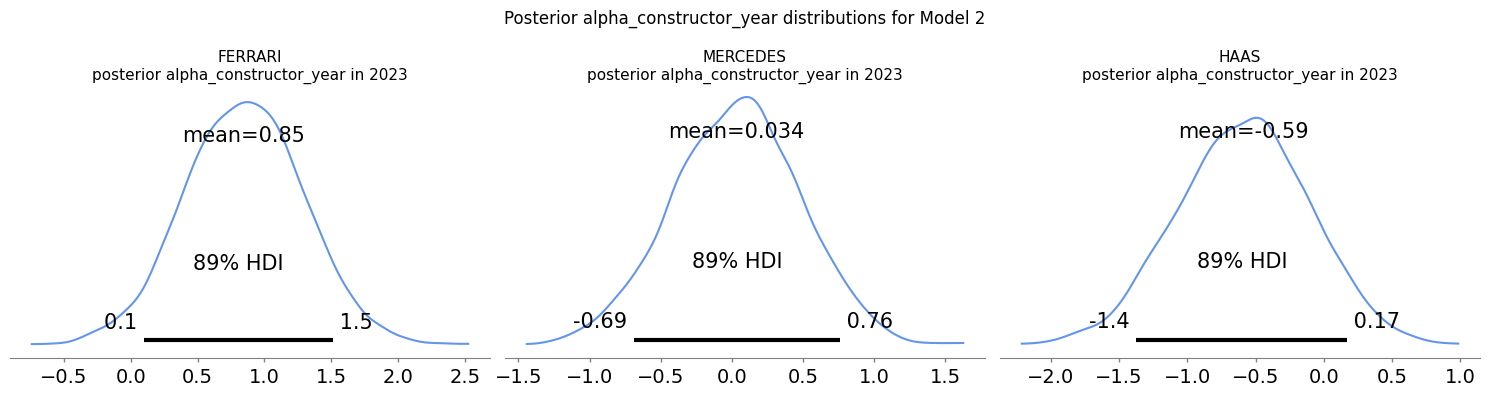

In [422]:
constructor_names = ['ferrari', 'mercedes', 'haas']
year = 2023
fig, axes = plt.subplots(1, len(constructor_names), figsize=(5 * len(constructor_names), 4), sharey=True)

for c_i, c_name in enumerate(constructor_names):
    constructor_id = team_id_map[c_name]
    az.plot_posterior(model_2_fit, var_names=["alpha_constructor_year"], coords={"alpha_constructor_year_dim_0": [season_id_map[year] - 1], "alpha_constructor_year_dim_1": [constructor_id - 1]}, ax=axes[c_i], color='cornflowerblue', hdi_prob=0.89)
    axes[c_i].set_title(c_name.upper() + '\nposterior alpha_constructor_year in ' + str(year), fontsize=11)

fig.suptitle("Posterior alpha_constructor_year distributions for Model 2")
fig.tight_layout()
plt.show()

#### Alpha Engine distribution

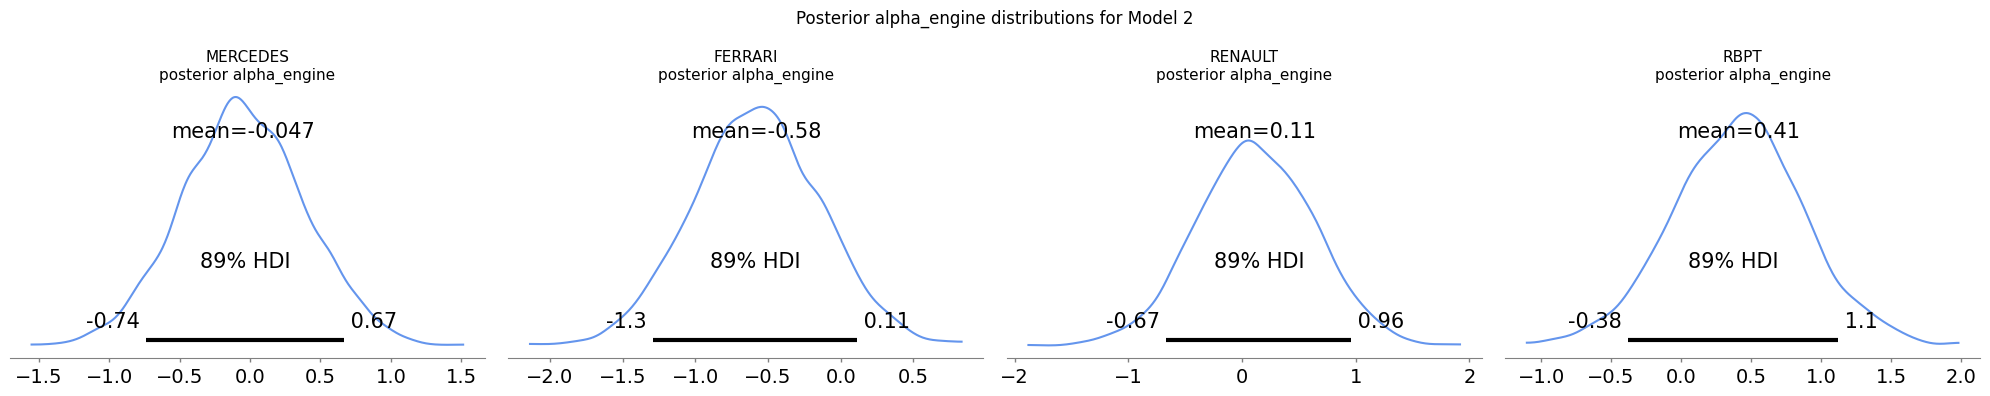

In [386]:
engine_names = ['mercedes', 'ferrari', 'renault', 'rbpt']
fig, axes = plt.subplots(1, len(engine_names), figsize=(5 * len(engine_names), 4), sharey=True)

for c_i, c_name in enumerate(engine_names):
    engine_id = engine_id_map[c_name]
    az.plot_posterior(model_2_fit, var_names=["alpha_engine"],coords={"alpha_engine_dim_0": [engine_id - 1]}, ax=axes[c_i], color='cornflowerblue', hdi_prob=0.89)
    axes[c_i].set_title(c_name.upper() + '\nposterior alpha_engine', fontsize=11)

fig.suptitle("Posterior alpha_engine distributions for Model 2")
fig.tight_layout()
plt.show()

### Driver skill trajectories

In [387]:
driver = az.summary(model_2_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.50)
driver['Driver_id'] = driver_id_map.values()
driver['Driver_name'] = driver_id_map.keys()

In [388]:
driver_rating = df[['DriverId', 'Rating_by_year', 'Season']]
driver_model2 = driver.merge(driver_rating, left_on='Driver_id', right_on='DriverId', how='left')

In [389]:
driver_model2['Skill_weighted_alpha'] = driver_model2['mean'] * driver_model2['Rating_by_year']
driver_model2['Skill_weighted_2_5'] = driver_model2['hdi_25%'] * driver_model2['Rating_by_year']
driver_model2['Skill_weighted_97_5'] = driver_model2['hdi_75%'] * driver_model2['Rating_by_year']

In [390]:
driver_season_counts = driver_model2.groupby('DriverId')['Season'].nunique()
drivers_in_all_seasons = driver_season_counts[driver_season_counts == n_seasons].index
df_filtered = driver_model1[driver_model2['DriverId'].isin(drivers_in_all_seasons)]
year_index_to_name = {v: k for k, v in season_id_map.items()}
df_filtered['Year'] = df_filtered['Season'].map(year_index_to_name)

/tmp/ipykernel_22/4065718161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = df_filtered['Season'].map(year_index_to_name)


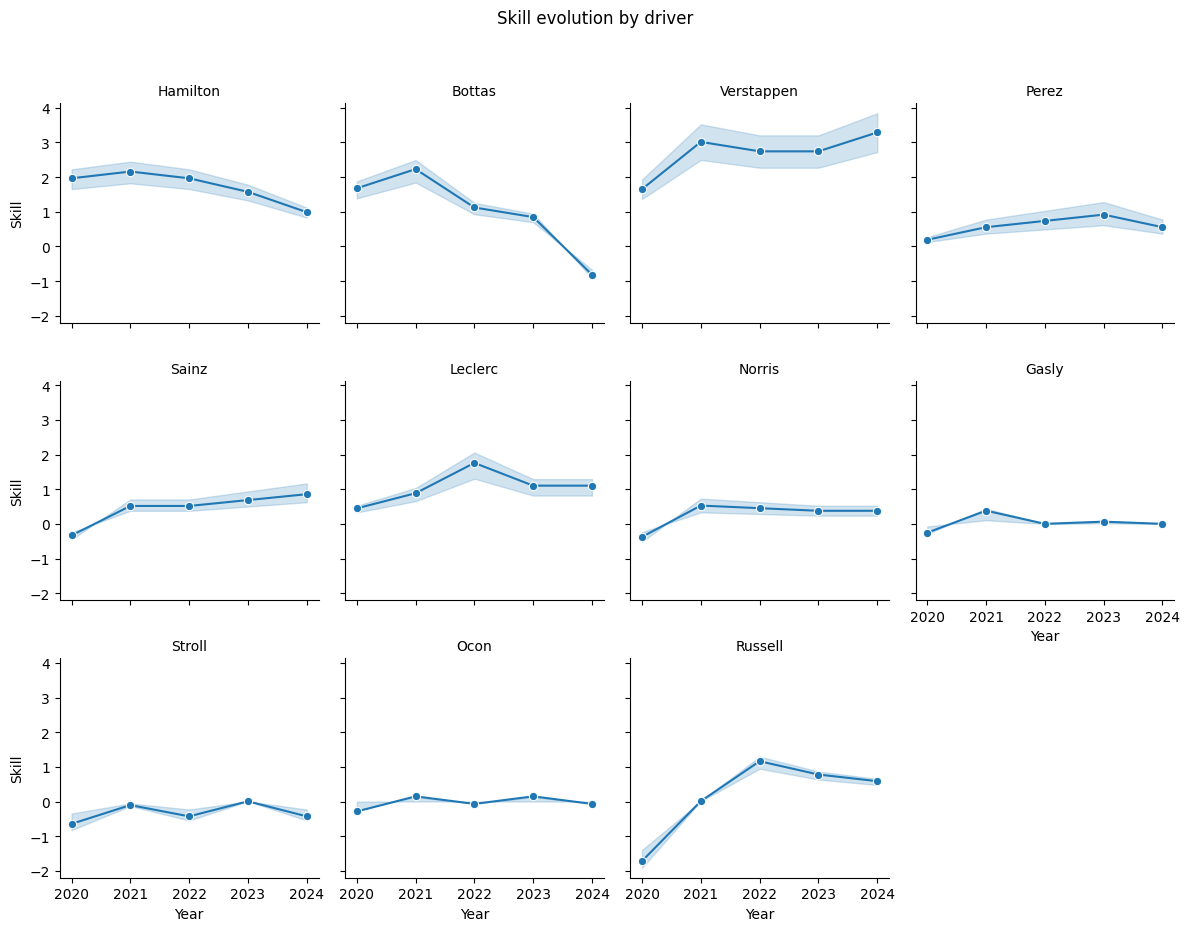

In [391]:
g = sns.FacetGrid(df_filtered, col='Driver_name', col_wrap=4, height=3, sharey=True)

# Linia i cieniowanie przedziału niepewności
g.map_dataframe(
    sns.lineplot, x='Year', y='Skill_weighted_alpha', marker='o'
)
g.map_dataframe(
    plt.fill_between, 'Year', 'Skill_weighted_2_5', 'Skill_weighted_97_5', alpha=0.2
)
g.set_axis_labels("Year", "Skill")
g.set_titles("{col_name}")
g.fig.suptitle("Skill evolution by driver", y=1.03)
plt.tight_layout()
plt.show()

### Constructor Rating in 2023

In [392]:
import re

def extract_indices(name):
    match = re.match(r"alpha_constructor_year\[(\d+), (\d+)\]", name)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        return None, None

In [394]:
constructor = az.summary(model_2_fit, var_names=['alpha_constructor_year'], kind='stats', hdi_prob=.50)
constructor = constructor.reset_index()

constructor[["year_idx", "constructor_idx"]] = constructor["index"].apply(
    lambda x: pd.Series(extract_indices(x))
)

team_index_to_name = {v - 1: k for k, v in processed_teams.items()}
year_index_to_name = {v - 1: k for k, v in season_id_map.items()}

constructor['Constructor_name'] = constructor["constructor_idx"].map(team_index_to_name)
constructor['Year'] = constructor["year_idx"].map(year_index_to_name)

constructor_list = constructor['Constructor_name'].tolist()

constructor_2023 = constructor[constructor['Year'] == 2023]

constructor_sorted = constructor_2023.sort_values(by=['mean'], ascending=True)
constructor_sorted.reset_index(drop=True, inplace=True)

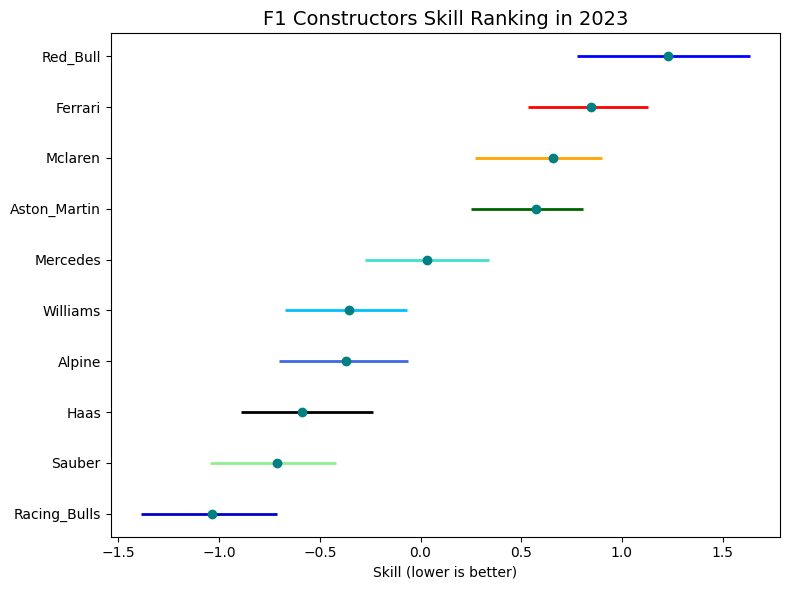

In [395]:
constructor_color = {'Ferrari': 'red', 'Mercedes': 'turquoise', 'Red_Bull': 'blue', 
                     'Williams': 'deepskyblue', 'Aston_Martin': 'darkgreen', 
                     'Racing_Bulls': 'mediumblue', 'Alpine': 'royalblue', 
                     'Sauber': 'lightgreen', 'Mclaren': 'orange', 'Haas': 'k'}

fig, ax = plt.subplots(figsize=(8, 6))

for i, row in constructor_sorted.iterrows():
    y = i
    x_mean = row['mean']
    x_min = row['hdi_25%']
    x_max = row['hdi_75%']

    ax.hlines(y, x_min, x_max, color=constructor_color[row['Constructor_name']], linewidth=2)

    ax.plot(x_mean, y, 'o', color='teal')

ax.set_yticks(range(len(constructor_sorted)))
ax.set_yticklabels(constructor_sorted['Constructor_name'], fontsize=10)

ax.set_xlabel("Skill (lower is better)")
ax.set_title("F1 Constructors Skill Ranking in 2023", fontsize=14)

plt.tight_layout()
plt.show()

### Constructor trajectories

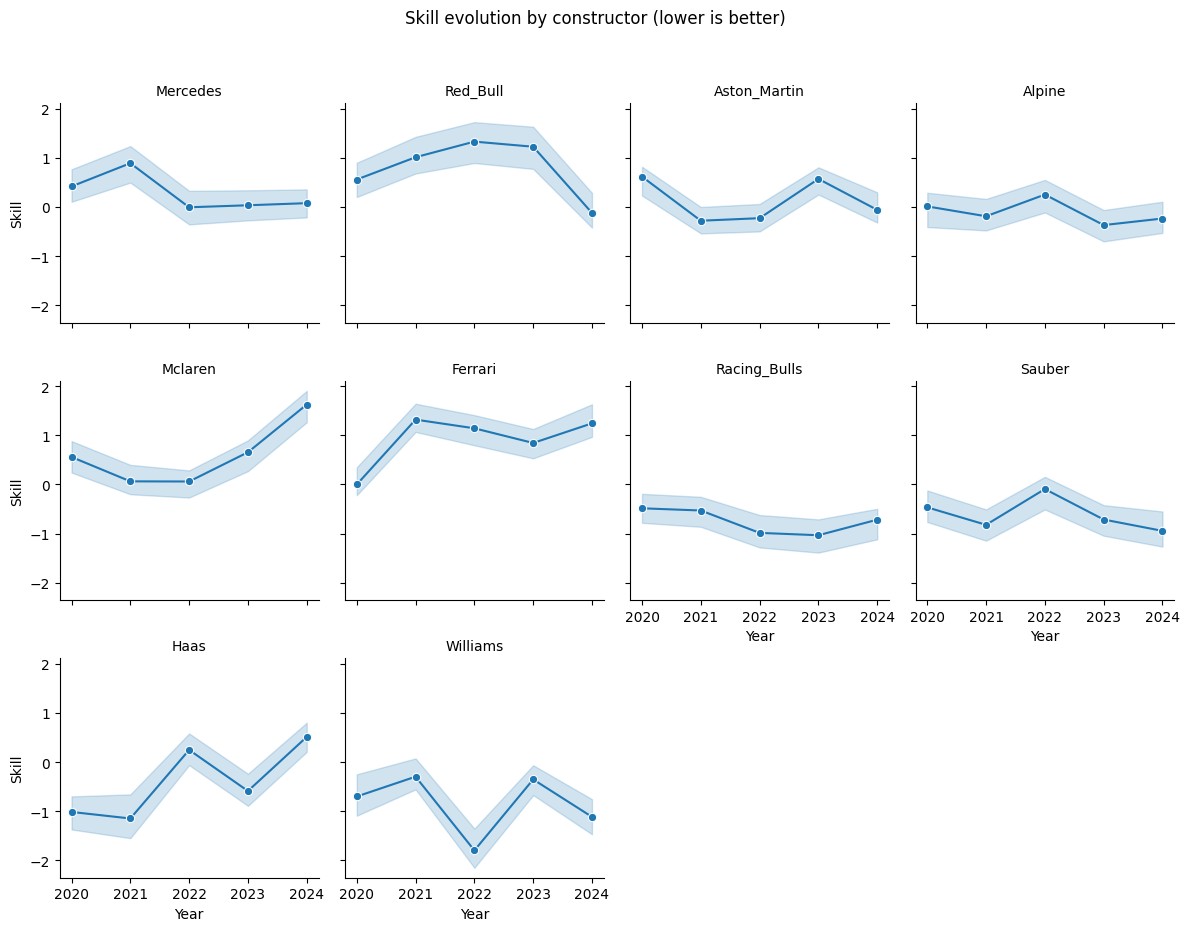

In [396]:
g = sns.FacetGrid(constructor, col='Constructor_name', col_wrap=4, height=3, sharey=True)

# Linia i cieniowanie przedziału niepewności
g.map_dataframe(
    sns.lineplot, x='Year', y='mean', marker='o'
)
g.map_dataframe(
    plt.fill_between, 'Year', 'hdi_25%', 'hdi_75%', alpha=0.2
)
g.set_axis_labels("Year", "Skill")
g.set_titles("{col_name}")
g.fig.suptitle("Skill evolution by constructor (lower is better)", y=1.03)
plt.tight_layout()
plt.show()

## Model comaprison [0-4 pts]
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

In [398]:
fit_1 = az.from_cmdstanpy(posterior=model_1_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_1_data['position'])

In [399]:
fit_2 = az.from_cmdstanpy(posterior=model_2_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_2_data['position'])

In [400]:
dict_compare = {
    'Model 1': fit_1,
    'Model 2': fit_2
}

#### Waic comparison

In [401]:
waic_compare = az.compare(dict_compare, ic='waic')
print(waic_compare)

         rank   elpd_waic     p_waic  elpd_diff    weight        se      dse  \
Model 2     0 -206.775740  34.690190   0.000000  0.840002  5.176315  0.00000   
Model 1     1 -223.907317  30.237793  17.131577  0.159998  9.399530  7.94209   

         warning scale  
Model 2     True   log  
Model 1     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


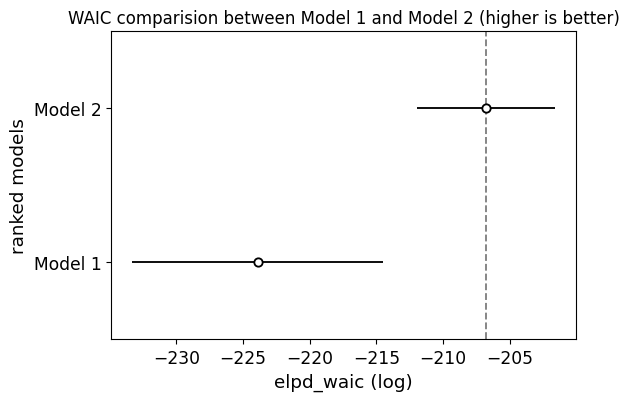

In [402]:
az.plot_compare(waic_compare, figsize=(6, 4))
plt.title('WAIC comparision between Model 1 and Model 2 (higher is better)')
plt.show()

Based on the WAIC comparison results, Model 2 outperforms Model 1. Model 2 has a higher expected log pointwise predictive density (elpd_waic = -206.78) compared to Model 1 (elpd_waic = -223.91), indicating better predictive accuracy. The difference in elpd_waic between the models is 17.13 in favor of Model 2.

To assess the statistical significance of this difference, we calculated the ratio of elpd_diff (17.13) to its standard error (dse = 7.94), which equals approximately 2.16. This ratio suggests that Model 2 generalizes better than Model 1, although the evidence is moderate.

Regarding model complexity, Model 2 has a higher effective number of parameters (p_waic = 34.69) than Model 1 (p_waic = 30.24), indicating it is more complex. Despite this, Model 2 achieves better generalization, suggesting the additional parameters improved performance.

Both models generated warnings during WAIC computation, indicating potential unreliability of the WAIC estimates, likely due to the high number of parameters in each model.

Finally, the model weights strongly favor Model 2 (weight = 0.84) over Model 1 (weight = 0.16), supporting the conclusion that Model 2 is the preferred model.

#### Psis-loo comparison

In [403]:
loo_compare = az.compare(dict_compare, ic='loo')
print(loo_compare)

         rank    elpd_loo      p_loo  elpd_diff    weight        se       dse  \
Model 2     0 -216.992330  44.906780   0.000000  0.620409  5.813943  0.000000   
Model 1     1 -227.158786  33.489262  10.166456  0.379591  9.681838  8.257788   

         warning scale  
Model 2     True   log  
Model 1     True   log  


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


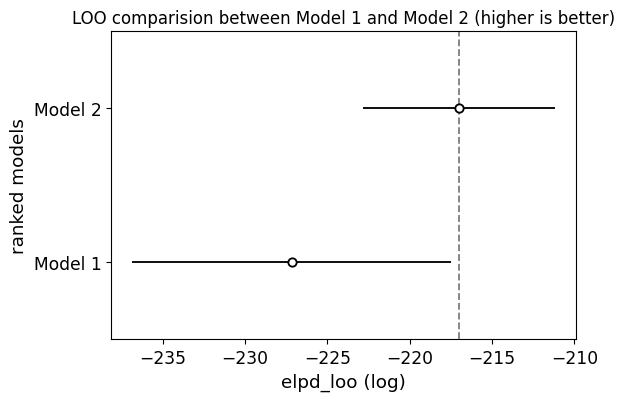

In [404]:
az.plot_compare(loo_compare, figsize=(6, 4))
plt.title('LOO comparision between Model 1 and Model 2 (higher is better)')
plt.show()

Based on the PSIS-LOO comparison, Model 2 outperforms Model 1. Model 2 achieves a higher expected log predictive density (elpd_loo = -216.99) compared to Model 1 (elpd_loo = -227.16), with an elpd difference of 10.17 favoring Model 2.

To assess the statistical significance of this difference, we calculated the ratio of elpd_diff (10.17) to its standard error (dse = 8.26), resulting in approximately 1.23. This suggests that Model 2 generalizes better than Model 1, although the evidence is relatively weak.

The effective number of parameters (p_loo) is greater for Model 2 (44.91) than for Model 1 (33.49), indicating higher complexity. Despite this increased complexity, Model 2 demonstrates better predictive performance, implying that the additional parameters contribute positively to the model.

Both models issued warnings during PSIS-LOO calculations, indicating potential reliability concerns with the estimates. These warnings typically arise from influential observations or problematic data points (high Pareto k values).

Finally, the model weights favor Model 2 (weight = 0.62) over Model 1 (weight = 0.38), supporting Model 2 as the preferred choice, though the strength of evidence is moderate.

## Summary

For both information criteria, we obtained similar results that confirmed our expectations — the more complex model performs better, as we anticipated. Additionally, model 2, by incorporating information about the engine and how a given team performed in a specific year, allows for more accurate predictions regarding whether a change of engine in a particular team or a driver in a given year could improve the results.

## Does the model suggest that Ocon could have achieved a better result than Perez in 2024 if he had been driving the Red Bull car?

In [414]:
driver = 'ocon'
team = 'red_bull'
engine = 'rbpt'
season_driver = 2024
season_constructor = 2024

results = model_2_fit.draws_pd()
driver_id  = driver_id_map[driver]
constructor_id = team_id_map[team]
engine_id = engine_id_map[engine]
year_id_driver = season_id_map[season_driver]
year_id_constructor = season_id_map[season_constructor]
rating = df[(df['DriverId'] == driver_id) & (df['Season'] == year_id_driver)]['Rating_by_year'].values[0]

model = (
    results[f'alpha_constructor_year[{year_id_constructor},{constructor_id}]'] 
    + results[f'alpha_engine[{engine_id}]'] 
    - results[f'alpha_driver[{driver_id}]'] * rating
)
model_list = model.tolist()
prob = expit(model_list) 
result = 20 - binomial(n=19, p=prob)

In [418]:
driver = 'perez'
driver_id  = driver_id_map[driver]
perez_2024 = df[(df['DriverId'] == driver_id) & (df['Season'] == year_id_driver)]['Position'].values[0]

In [480]:
prop_ocon_readbull = np.mean(result > perez_2024)
print(f"P(Ocon > Perez) = {prop_ocon_readbull:.3f}")
print(f'According to the model, if Ocon had driven for RedBull in the 2024 season, there is a {100* prop_ocon_readbull:.1f}% probability that he would have finished the season in a\nbetter position than Perez did in reality.')

P(Ocon > Perez) = 0.472
According to the model, if Ocon had driven for RedBull in the 2024 season, there is a 47.2% probability that he would have finished the season in a
better position than Perez did in reality.


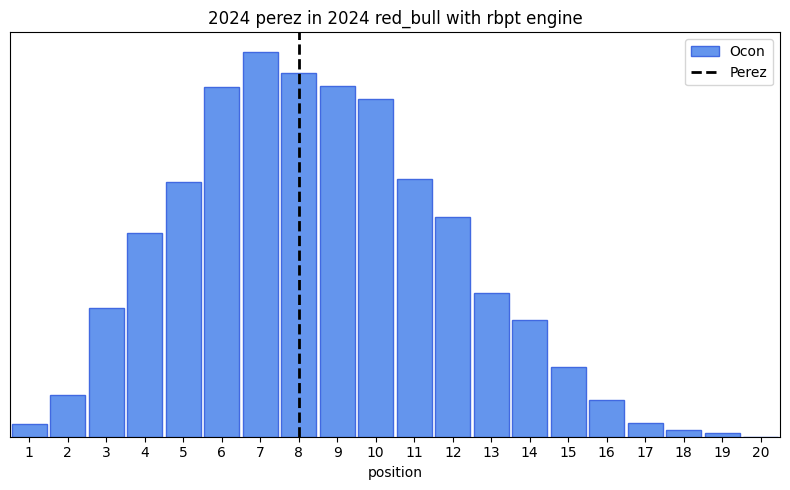

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

n_bins = np.arange(22) - 0.5

ax.hist(result, bins=n_bins, rwidth=0.9, color='cornflowerblue', edgecolor='royalblue', density=True, alpha=1, label='Ocon')
ax.set_xticks(range(22))
ax.set_xlim([0.5, 20.5])
ax.set_yticks([])
ax.set_title(f'{season_driver} {driver} in {season_constructor} {team} with {engine} engine')
ax.set_xlabel(r'position')
ax.axvline(perez_2024, color='black', linestyle='--', linewidth=2, label="Perez")
ax.legend()

fig.tight_layout()
plt.show()

## Bibliography

van Kesteren, E.-J., & Bergkamp, T. (2023). Bayesian analysis of Formula One race results: Disentangling driver skill and constructor advantage. Journal of Quantitative Analysis in Sports, 19(4), 273–293. https://doi.org/10.1515/jqas-2022-0021